In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
folder_path = "/content/drive/MyDrive/DL_Project"

os.makedirs(folder_path, exist_ok=True)

### Load Dataset

In [ ]:
!wget 'https://archive.ics.uci.edu/static/public/1101/pirvision_fog_presence_detection.zip'

--2025-04-13 09:09:38--  https://archive.ics.uci.edu/static/public/1101/pirvision_fog_presence_detection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pirvision_fog_presence_detection.zip.2’

pirvision_fog_prese     [  <=>               ]   1.68M  4.26MB/s    in 0.4s    

2025-04-13 09:09:39 (4.26 MB/s) - ‘pirvision_fog_presence_detection.zip.2’ saved [1759942]



In [ ]:
!unzip '/content/pirvision_fog_presence_detection.zip'

Archive:  /content/pirvision_fog_presence_detection.zip
replace pirvision_office_dataset1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
data = pd.read_csv('/content/pirvision_office_dataset1.csv')
data['Label'] = data['Label'].replace({3: 2})
len(data)

7651

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7651 entries, 0 to 7650
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           7651 non-null   object
 1   Time           7651 non-null   object
 2   Label          7651 non-null   int64 
 3   Temperature_F  7651 non-null   int64 
 4   PIR_1          7651 non-null   int64 
 5   PIR_2          7651 non-null   int64 
 6   PIR_3          7651 non-null   int64 
 7   PIR_4          7651 non-null   int64 
 8   PIR_5          7651 non-null   int64 
 9   PIR_6          7651 non-null   int64 
 10  PIR_7          7651 non-null   int64 
 11  PIR_8          7651 non-null   int64 
 12  PIR_9          7651 non-null   int64 
 13  PIR_10         7651 non-null   int64 
 14  PIR_11         7651 non-null   int64 
 15  PIR_12         7651 non-null   int64 
 16  PIR_13         7651 non-null   int64 
 17  PIR_14         7651 non-null   int64 
 18  PIR_15         7651 non-null

In [ ]:
data.head()

,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
0,2024-08-08,19:19:56,0,86,10269,10721,11156,11170,10931,10671,...,11178,11197,11161,11096,10957,10839,10735,10590,10411,10329
1,2024-08-08,19:20:12,1,86,10364,10907,11299,11238,10867,10535,...,11122,11145,11136,11108,11041,10824,10645,10493,10398,10357
2,2024-08-08,19:20:28,0,86,10329,10793,11197,11242,11052,10658,...,11168,11204,11162,11109,11007,10867,10700,10533,10427,10265
3,2024-08-08,19:20:44,0,86,10169,10425,10822,11133,11136,10834,...,11116,11273,11186,10984,10910,10807,10714,10651,10562,10463
4,2024-08-08,19:21:00,0,86,10320,10667,11104,11234,11129,10814,...,11006,11257,11370,11173,10924,10816,10754,10588,10428,10407


In [ ]:
data.describe()

,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,PIR_7,PIR_8,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
count,7651.000000,7651.000000,7.651000e+03,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,...,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
mean,0.258136,80.383871,2.501256e+05,11013.891648,11517.838452,11578.490786,11269.104169,10795.036989,10312.208600,9907.840413,...,11460.947458,11559.512874,11541.448438,11439.599529,11283.987061,11103.084564,10919.279441,10743.028624,10585.803294,10449.395373
std,0.583788,22.861417,4.292998e+06,591.799276,656.683841,663.111916,605.936126,537.247861,501.407122,499.632397,...,599.157249,627.996166,619.196749,598.563183,571.520024,546.310552,518.341483,487.208570,464.748286,450.231316
min,0.000000,0.000000,2.613000e+03,2615.000000,2614.000000,2611.000000,2612.000000,2613.000000,2616.000000,2614.000000,...,2606.000000,2606.000000,2606.000000,2605.000000,2605.000000,2609.000000,2605.000000,2604.000000,2603.000000,2602.000000
25%,0.000000,86.000000,1.033300e+04,10787.500000,11272.500000,11338.000000,11051.000000,10629.000000,10182.000000,9764.000000,...,11222.000000,11313.000000,11301.000000,11211.000000,11083.000000,10935.500000,10794.000000,10650.000000,10513.000000,10388.000000
50%,0.000000,86.000000,1.043100e+04,11002.000000,11557.000000,11629.000000,11301.000000,10790.000000,10311.000000,9910.000000,...,11488.000000,11583.000000,11566.000000,11471.000000,11319.000000,11137.000000,10948.000000,10760.000000,10597.000000,10454.000000
75%,0.000000,88.000000,1.056050e+04,11267.000000,11885.000000,11957.000000,11550.000000,10982.000000,10443.000000,10035.000000,...,11837.000000,11961.000000,11928.000000,11781.000000,11571.000000,11334.000000,11097.000000,10876.000000,10683.000000,10524.000000
max,2.000000,89.000000,1.116026e+08,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000


In [ ]:
data['Date'].unique()

array(['2024-08-08', '2024-09-08', '2024-10-08'], dtype=object)

### Class Count

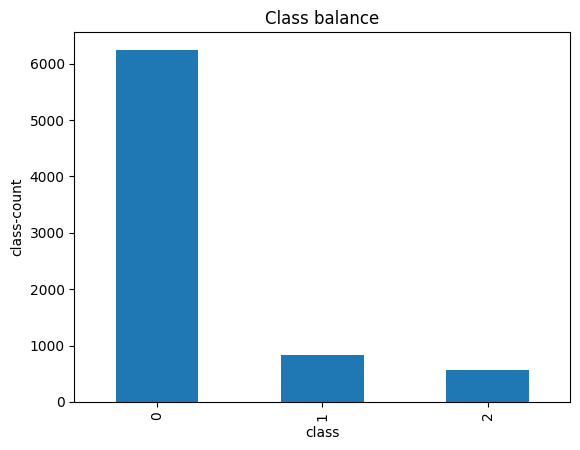

In [ ]:
import matplotlib.pyplot as plt
class_cnt = data.value_counts("Label")
class_cnt.plot(kind = "bar")
plt.xlabel("class")
plt.ylabel("class-count")
plt.title("Class balance")
plt.show()

In [ ]:
classes = np.unique(data['Label'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=data['Label'])
print(dict(zip(classes, class_weights)))

{np.int64(0): np.float64(0.40824929299397045), np.int64(1): np.float64(3.0616246498599438), np.int64(2): np.float64(4.466433158201985)}


### Prepare data to train

 All features, including temperature and PIR sensor readings, were normalized using MinMaxScaler to bring values into a uniform scale between 0 and 1. This was essential for ensuring faster convergence and preventing any single feature from dominating the learning process.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%d-%m', errors='coerce')
data['Date'] = data['Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else 0)
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce')
data['Time'] = data['Time'].dt.hour * 3600 + data['Time'].dt.minute * 60 + data['Time'].dt.second

# effective for LSTM-based models

feature_columns = ['Date', 'Time', 'Temperature_F'] + [f'PIR_{i}' for i in range(1, 56)]

X = data[feature_columns]
y = data['Label']

from sklearn.model_selection import train_test_split

y_train = y

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X)

X_train = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X.index)

In [ ]:
print("X_train_scaled shape:", X_train.shape)
print("X_train - columns", X_train.columns)

X_train_scaled shape: (7651, 58)
X_train - columns Index(['Date', 'Time', 'Temperature_F', 'PIR_1', 'PIR_2', 'PIR_3', 'PIR_4',
       'PIR_5', 'PIR_6', 'PIR_7', 'PIR_8', 'PIR_9', 'PIR_10', 'PIR_11',
       'PIR_12', 'PIR_13', 'PIR_14', 'PIR_15', 'PIR_16', 'PIR_17', 'PIR_18',
       'PIR_19', 'PIR_20', 'PIR_21', 'PIR_22', 'PIR_23', 'PIR_24', 'PIR_25',
       'PIR_26', 'PIR_27', 'PIR_28', 'PIR_29', 'PIR_30', 'PIR_31', 'PIR_32',
       'PIR_33', 'PIR_34', 'PIR_35', 'PIR_36', 'PIR_37', 'PIR_38', 'PIR_39',
       'PIR_40', 'PIR_41', 'PIR_42', 'PIR_43', 'PIR_44', 'PIR_45', 'PIR_46',
       'PIR_47', 'PIR_48', 'PIR_49', 'PIR_50', 'PIR_51', 'PIR_52', 'PIR_53',
       'PIR_54', 'PIR_55'],
      dtype='object')


In [ ]:
train_sequences = torch.tensor(X_train.values[:, :, None], dtype=torch.float32)  # (n_train, 58, 1)
# To consider data as one feature
train_seq_labels = torch.tensor(y_train.values, dtype=torch.long)

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


train_dataset = TimeSeriesDataset(train_sequences, train_seq_labels)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM & GRU & RNN

Time series classification task -> RNN-based models are selected RNN, LSTM, and GRU

- RNNs capable of learning short-term dependencies but limited by vanishing gradients in longer sequences.
- LSTMs, which use gating mechanisms to retain long-term context
- GRUs are more efficient with fewer parameters, making them ideal for faster training on moderate-sized datasets.

- CNNs to extract local temporal patterns


### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, num_cols, input_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out


# Test Config
input_size = train_sequences.shape[2]
hidden_size = 100
num_layers = 2
output_size = 3

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.3)
model.to(device)
print(model)

LSTMModel(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


### GRU

In [ ]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, num_cols, input_size)
        batch_size = x.size(0)
        # Initialize hidden state for GRU
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)  # out: (batch_size, num_cols, hidden_size)
        out = out[:, -1, :]
        out = self.fc(out)        # map to output space
        return out

# Test Config
input_size = train_sequences.shape[2]  # number of features
hidden_size = 100
num_layers = 2
output_size = 3
dropout = 0.3

gru_model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout)
gru_model.to(device)
print("GRU Model:\n", gru_model)

GRU Model:
 GRUModel(
  (gru): GRU(1, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


### RNN

In [ ]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # built-in RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, num_cols, input_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)  # out: (batch_size, num_cols, hidden_size)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Test Config
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size, dropout)
rnn_model.to(device)
print("RNN Model:\n", rnn_model)


RNN Model:
 RNNModel(
  (rnn): RNN(1, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


### Compute Metrices

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def evaluation(true_labels, pred_labels):
  correct = np.sum(pred_labels == true_labels)
  total = len(true_labels)
  accuracy = correct/total
  labels = [0, 2, 1]

  macro_f1 = f1_score(true_labels, pred_labels ,average ='macro', labels = labels)
  report = classification_report(true_labels, pred_labels, target_names =['Class 0', 'Class 3', 'Class 1'], labels = labels)
  conf_matrix = confusion_matrix(true_labels, pred_labels, labels = labels)

  print(f"Macro f1 { macro_f1}")
  print(f"Classification report \n {report}")
  print(f"Confusion matrix \n{conf_matrix}")

  return accuracy, macro_f1, report, conf_matrix

### Cross Validation

To Generalizable performance -> 5-fold cross-validation strategy is used training.

Partitioned the dataset into five splits, cycling through each as a validation set while training on the remaining folds. -> Reduces Overfitting

Grid Search used for Hyperparameter tuning

For testing, we evaluated the best model (selected based on validation F1-score)

In [ ]:
def cross_val(model_class, model_params, train_seq, train_seq_labels,
              batch_size, num_epochs, learning_rate, weight_tensor, device):
    num_train_samples = train_seq.size(0)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Caching for plots
    fold_accuracies = []
    fold_val_losses = []
    train_losses_per_fold = []
    val_losses_per_fold = []
    train_accuracies_per_fold = []
    val_accuracies_per_fold = []

    best_f1 = 0
    best_report = None
    best_mat = None
    best_model = None
    best_optimizer = None

    for fold, (train_ind, val_ind) in enumerate(kf.split(np.arange(num_train_samples)), 1):
        print(f"\n Fold {fold}")
        # Split into Fold Train & Validation Sets
        fold_train_seq = train_seq[train_ind]
        fold_train_labels = train_seq_labels[train_ind]
        fold_val_seq = train_seq[val_ind]
        fold_val_labels = train_seq_labels[val_ind]

        # Convert to Loader objects
        train_data_fold = TimeSeriesDataset(fold_train_seq, fold_train_labels)
        val_data_fold = TimeSeriesDataset(fold_val_seq, fold_val_labels)
        train_loader_fold = DataLoader(train_data_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_data_fold, batch_size=batch_size, shuffle=False)

        # Initialize Model
        model = model_class(**model_params).to(device)
        # Initialize Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        # Training
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            correct_train = 0
            total_samples = 0

            for inputs, targets in train_loader_fold:
                inputs = inputs.to(device)
                targets = targets.to(device).view(-1)

                optimizer.zero_grad() # Set grad to 0
                outputs = model(inputs) # Forward Prop
                loss = criterion(outputs, targets) # Compute Loss
                loss.backward() # Backprop
                optimizer.step()

                batch_size_current = inputs.size(0)
                epoch_loss += loss.item() * batch_size_current
                correct_train += (torch.argmax(outputs, dim=1) == targets).sum().item()
                total_samples += batch_size_current

            avg_train_loss = epoch_loss / total_samples
            train_accuracy = correct_train / total_samples

            train_loss_history.append(avg_train_loss)
            train_acc_history.append(train_accuracy)

            print(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        total_val = 0
        correct_val = 0
        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for inputs, targets in val_loader_fold:
                inputs = inputs.to(device)
                targets = targets.to(device).view(-1)

                outputs = model(inputs) # Forward Prop
                loss = criterion(outputs, targets) # Compute Loss

                val_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                # correct_val += (pred == targets).sum().item()
                total_val += targets.size(0)

                true_labels.extend(targets.cpu().numpy())
                pred_labels.extend(pred.cpu().numpy())

        avg_val_loss = val_loss / total_val
        val_loss_history.append(avg_val_loss)

        # Save per-fold metrics
        train_losses_per_fold.append(train_loss_history)
        val_losses_per_fold.append(val_loss_history)
        train_accuracies_per_fold.append(train_acc_history)

        true_labels = np.array(true_labels)
        pred_labels = np.array(pred_labels)

        # Compute Accuracy, F1 Score, Recall and per class metric
        fold_accuracy, fold_macro_f1, fold_report, fold_conf_matrix = evaluation(true_labels, pred_labels)

        # Storing the best hyperparameter - Grid Search
        if fold_macro_f1 > best_f1:
            best_f1 = fold_macro_f1
            best_report = fold_report
            best_mat = fold_conf_matrix
            best_model = model
            best_optimizer = optimizer

        print(f"Fold {fold}, Validation Accuracy: {fold_accuracy * 100:.2f}")
        print(f"Fold {fold}, Val Loss = {avg_val_loss:.4f}")

        fold_accuracies.append(fold_accuracy)
        fold_val_losses.append(avg_val_loss)

    avg_cv_loss = np.mean(fold_val_losses)
    avg_cv_accuracy = np.mean(fold_accuracies)

    print("\nAverage Cross-Validation Loss: {:.4f}".format(avg_cv_loss))
    print("Average Cross-Validation Accuracy: {:.4f}".format(avg_cv_accuracy))

    return {
        "fold_acc": fold_accuracies,
        "acc": avg_cv_accuracy,
        "fold_loss": fold_val_losses,
        "loss": avg_cv_loss,
        "loss_curve": {
            "train": train_losses_per_fold,
            "val": val_losses_per_fold
        },
        "acc_curve": {
            "train": train_accuracies_per_fold,
            "val": fold_accuracies
        },
        "best": {
            "acc": max(fold_accuracies),
            "report": best_report,
            "mat": best_mat,
            "f1": best_f1,
            "model": best_model,
            "optimizer": best_optimizer
        },
        "mean-acc": statistics.mean(fold_accuracies),
        "std-acc": statistics.stdev(fold_accuracies)
    }


### Grid Search

In [ ]:
import itertools

hidden_sizes = [50, 100]
num_layers_list = [1, 2]
dropouts = [0.0, 0.3]
learning_rates = [0.001, 0.0005]

input_size = train_sequences.shape[2]  # Feature Count
output_size = 3                        # for 3-class classification
num_epochs = 10
batch_size = 32

In [ ]:
model_classes = {
    'LSTM': LSTMModel,
    'GRU': GRUModel,
    'RNN': RNNModel
}

best_results = {}

for model_name, model_class in model_classes.items():
    print(f"\n\nRunning Grid Search for {model_name}")
    best_f1 = 0

    # Define Weight for Optimizer & Loss
    weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)

    for hidden_size, num_layers, dropout, lr in itertools.product(hidden_sizes, num_layers_list, dropouts, learning_rates):
        # Define Model Params
        model_params = {
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'output_size': output_size,
            'dropout': dropout
        }
        print("\n")
        print(f"Model: {model_name}, hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")
        # Cross Validation
        cv_result = cross_val(model_class, model_params, train_sequences, train_seq_labels, batch_size, num_epochs, lr, weight_tensor, device)
        # Trained Model
        trained_model = cv_result["best"]["model"]

        if cv_result["best"]["f1"] > best_f1:
            # Store the best hyper params
            best_f1 =  cv_result["best"]["f1"]
            best_results[model_name] = {
                "hyperparams" : model_params,
                "f1": best_f1,
                "report": cv_result["best"]["report"],
                "conf_mat": cv_result["best"]["mat"],
                "lr": lr
            }



Running Grid Search for LSTM


Model: LSTM, hidden_size=50, num_layers=1, dropout=0.0, lr=0.001

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0970, Train Acc = 0.8052
Fold 1, Epoch 2/10, Train Loss = 1.0967, Train Acc = 0.7995
Fold 1, Epoch 3/10, Train Loss = 1.0892, Train Acc = 0.7830
Fold 1, Epoch 4/10, Train Loss = 1.0342, Train Acc = 0.8299
Fold 1, Epoch 5/10, Train Loss = 0.5256, Train Acc = 0.6668
Fold 1, Epoch 6/10, Train Loss = 0.4657, Train Acc = 0.6606
Fold 1, Epoch 7/10, Train Loss = 0.4078, Train Acc = 0.7173
Fold 1, Epoch 8/10, Train Loss = 0.3593, Train Acc = 0.8109
Fold 1, Epoch 9/10, Train Loss = 0.3034, Train Acc = 0.8742
Fold 1, Epoch 10/10, Train Loss = 0.2762, Train Acc = 0.8859
Macro f1 0.7939216096471208
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.79      0.88      1243
     Class 3       0.98      0.97      0.98       129
     Class 1       0.37      0.94      0.53       159

    accuracy          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Macro f1 0.3010752688172043
Classification report 
               precision    recall  f1-score   support

     Class 0       0.82      1.00      0.90      1260
     Class 3       0.00      0.00      0.00       102
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.82      1530
   macro avg       0.27      0.33      0.30      1530
weighted avg       0.68      0.82      0.74      1530

Confusion matrix 
[[1260    0    0]
 [ 102    0    0]
 [ 168    0    0]]
Fold 5, Validation Accuracy: 82.35
Fold 5, Val Loss = 1.0524

Average Cross-Validation Loss: 0.4355
Average Cross-Validation Accuracy: 0.8949


Model: LSTM, hidden_size=50, num_layers=1, dropout=0.3, lr=0.001

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0966, Train Acc = 0.5219
Fold 1, Epoch 2/10, Train Loss = 1.0972, Train Acc = 0.7649
Fold 1, Epoch 3/10, Train Loss = 1.0933, Train Acc = 0.7160
Fold 1, Epoch 4/10, Train Loss = 1.0973, Train Acc = 0.8176
Fold 1, Epoch 5/10, Train Loss = 1.0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0972, Train Acc = 0.7471
Fold 2, Epoch 2/10, Train Loss = 1.0966, Train Acc = 0.8185
Fold 2, Epoch 3/10, Train Loss = 0.9752, Train Acc = 0.7786
Fold 2, Epoch 4/10, Train Loss = 0.4796, Train Acc = 0.6816
Fold 2, Epoch 5/10, Train Loss = 0.3942, Train Acc = 0.7879
Fold 2, Epoch 6/10, Train Loss = 0.3354, Train Acc = 0.8476
Fold 2, Epoch 7/10, Train Loss = 0.3059, Train Acc = 0.8718
Fold 2, Epoch 8/10, Train Loss = 0.2543, Train Acc = 0.9020
Fold 2, Epoch 9/10, Train Loss = 0.2810, Train Acc = 0.8881
Fold 2, Epoch 10/10, Train Loss = 0.2580, Train Acc = 0.8985
Macro f1 0.9183847052045578
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97      1237
     Class 3       0.98      0.96      0.97       125
     Class 1       0.80      0.82      0.81       168

    accuracy                           0.96      1530
   macro avg       0.92      0.92      0.92      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0976, Train Acc = 0.8005
Fold 3, Epoch 2/10, Train Loss = 1.0968, Train Acc = 0.6811
Fold 3, Epoch 3/10, Train Loss = 1.0539, Train Acc = 0.8205
Fold 3, Epoch 4/10, Train Loss = 0.8004, Train Acc = 0.5950
Fold 3, Epoch 5/10, Train Loss = 0.5753, Train Acc = 0.6306
Fold 3, Epoch 6/10, Train Loss = 0.7503, Train Acc = 0.5765
Fold 3, Epoch 7/10, Train Loss = 0.5161, Train Acc = 0.5151
Fold 3, Epoch 8/10, Train Loss = 0.5241, Train Acc = 0.5213
Fold 3, Epoch 9/10, Train Loss = 0.4335, Train Acc = 0.6027
Fold 3, Epoch 10/10, Train Loss = 0.4424, Train Acc = 0.7481
Macro f1 0.70716188121555
Classification report 
               precision    recall  f1-score   support

     Class 0       0.96      0.79      0.87      1242
     Class 3       0.50      0.94      0.66       124
     Class 1       0.47      0.82      0.60       164

    accuracy                           0.80      1530
   macro avg       0.65      0.85      0.71      1530
weighted avg       0.87

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0993, Train Acc = 0.7543
Fold 4, Epoch 2/10, Train Loss = 1.0974, Train Acc = 0.7314
Fold 4, Epoch 3/10, Train Loss = 0.8851, Train Acc = 0.7260
Fold 4, Epoch 4/10, Train Loss = 0.4978, Train Acc = 0.6729
Fold 4, Epoch 5/10, Train Loss = 0.4643, Train Acc = 0.6684
Fold 4, Epoch 6/10, Train Loss = 0.4331, Train Acc = 0.7002
Fold 4, Epoch 7/10, Train Loss = 0.4051, Train Acc = 0.7468
Fold 4, Epoch 8/10, Train Loss = 0.3933, Train Acc = 0.7678
Fold 4, Epoch 9/10, Train Loss = 0.3624, Train Acc = 0.7942
Fold 4, Epoch 10/10, Train Loss = 0.3350, Train Acc = 0.8370
Macro f1 0.8998134276598696
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.93      0.96      1265
     Class 3       0.99      0.95      0.97        91
     Class 1       0.65      0.96      0.77       174

    accuracy                           0.93      1530
   macro avg       0.88      0.94      0.90      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0987, Train Acc = 0.8147
Fold 5, Epoch 2/10, Train Loss = 1.0974, Train Acc = 0.7412
Fold 5, Epoch 3/10, Train Loss = 1.0055, Train Acc = 0.7713
Fold 5, Epoch 4/10, Train Loss = 0.5249, Train Acc = 0.6082
Fold 5, Epoch 5/10, Train Loss = 0.4388, Train Acc = 0.7020
Fold 5, Epoch 6/10, Train Loss = 0.4215, Train Acc = 0.7567
Fold 5, Epoch 7/10, Train Loss = 0.3551, Train Acc = 0.8227
Fold 5, Epoch 8/10, Train Loss = 0.3502, Train Acc = 0.8356
Fold 5, Epoch 9/10, Train Loss = 0.3204, Train Acc = 0.8544
Fold 5, Epoch 10/10, Train Loss = 0.2853, Train Acc = 0.8817
Macro f1 0.7902455955911963
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.80      0.89      1260
     Class 3       0.87      0.94      0.91       102
     Class 1       0.41      0.98      0.57       168

    accuracy                           0.83      1530
   macro avg       0.76      0.91      0.79      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0982, Train Acc = 0.6136
Fold 1, Epoch 2/10, Train Loss = 1.0969, Train Acc = 0.8176
Fold 1, Epoch 3/10, Train Loss = 1.0971, Train Acc = 0.8176
Fold 1, Epoch 4/10, Train Loss = 1.0946, Train Acc = 0.8188
Fold 1, Epoch 5/10, Train Loss = 1.0959, Train Acc = 0.8183
Fold 1, Epoch 6/10, Train Loss = 1.0948, Train Acc = 0.7933
Fold 1, Epoch 7/10, Train Loss = 0.6717, Train Acc = 0.7168
Fold 1, Epoch 8/10, Train Loss = 0.4630, Train Acc = 0.6552
Fold 1, Epoch 9/10, Train Loss = 0.4332, Train Acc = 0.6866
Fold 1, Epoch 10/10, Train Loss = 0.3828, Train Acc = 0.7518
Macro f1 0.7532472500718695
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.71      0.83      1243
     Class 3       0.99      0.96      0.98       129
     Class 1       0.30      0.96      0.46       159

    accuracy                           0.76      1531
   macro avg       0.76      0.88      0.75      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0982, Train Acc = 0.7857
Fold 2, Epoch 2/10, Train Loss = 1.0958, Train Acc = 0.8185
Fold 2, Epoch 3/10, Train Loss = 1.0955, Train Acc = 0.8185
Fold 2, Epoch 4/10, Train Loss = 1.0950, Train Acc = 0.8187
Fold 2, Epoch 5/10, Train Loss = 1.0429, Train Acc = 0.8247
Fold 2, Epoch 6/10, Train Loss = 0.5566, Train Acc = 0.6646
Fold 2, Epoch 7/10, Train Loss = 0.3931, Train Acc = 0.8048
Fold 2, Epoch 8/10, Train Loss = 0.3206, Train Acc = 0.8567
Fold 2, Epoch 9/10, Train Loss = 0.2770, Train Acc = 0.9075
Fold 2, Epoch 10/10, Train Loss = 0.3099, Train Acc = 0.8861
Macro f1 0.8879783768731415
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.92      0.95      1237
     Class 3       0.98      0.94      0.96       125
     Class 1       0.62      0.96      0.75       168

    accuracy                           0.93      1530
   macro avg       0.86      0.94      0.89      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0982, Train Acc = 0.4802
Fold 3, Epoch 2/10, Train Loss = 1.0967, Train Acc = 0.7759
Fold 3, Epoch 3/10, Train Loss = 1.0958, Train Acc = 0.6169
Fold 3, Epoch 4/10, Train Loss = 1.0942, Train Acc = 0.8196
Fold 3, Epoch 5/10, Train Loss = 0.7223, Train Acc = 0.8095
Fold 3, Epoch 6/10, Train Loss = 0.3550, Train Acc = 0.8419
Fold 3, Epoch 7/10, Train Loss = 0.3368, Train Acc = 0.8451
Fold 3, Epoch 8/10, Train Loss = 0.2897, Train Acc = 0.8923
Fold 3, Epoch 9/10, Train Loss = 0.2576, Train Acc = 0.9103
Fold 3, Epoch 10/10, Train Loss = 0.2470, Train Acc = 0.9110
Macro f1 0.8195981557668613
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.85      0.92      1242
     Class 3       0.97      0.90      0.93       124
     Class 1       0.45      0.95      0.61       164

    accuracy                           0.87      1530
   macro avg       0.80      0.90      0.82      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0990, Train Acc = 0.5194
Fold 4, Epoch 2/10, Train Loss = 1.0976, Train Acc = 0.8149
Fold 4, Epoch 3/10, Train Loss = 1.0987, Train Acc = 0.8144
Fold 4, Epoch 4/10, Train Loss = 1.0971, Train Acc = 0.8157
Fold 4, Epoch 5/10, Train Loss = 1.0464, Train Acc = 0.7843
Fold 4, Epoch 6/10, Train Loss = 0.5209, Train Acc = 0.6860
Fold 4, Epoch 7/10, Train Loss = 0.3711, Train Acc = 0.8028
Fold 4, Epoch 8/10, Train Loss = 0.3595, Train Acc = 0.8481
Fold 4, Epoch 9/10, Train Loss = 0.3188, Train Acc = 0.8783
Fold 4, Epoch 10/10, Train Loss = 0.3323, Train Acc = 0.8647
Macro f1 0.8176116926792498
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.89      0.94      1265
     Class 3       0.65      0.91      0.76        91
     Class 1       0.62      0.95      0.75       174

    accuracy                           0.90      1530
   macro avg       0.76      0.92      0.82      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0973, Train Acc = 0.6071
Fold 5, Epoch 2/10, Train Loss = 1.0963, Train Acc = 0.8156
Fold 5, Epoch 3/10, Train Loss = 1.0844, Train Acc = 0.8205
Fold 5, Epoch 4/10, Train Loss = 0.5390, Train Acc = 0.7146
Fold 5, Epoch 5/10, Train Loss = 0.4226, Train Acc = 0.7672
Fold 5, Epoch 6/10, Train Loss = 0.3868, Train Acc = 0.7799
Fold 5, Epoch 7/10, Train Loss = 0.3273, Train Acc = 0.8616
Fold 5, Epoch 8/10, Train Loss = 0.3204, Train Acc = 0.8665
Fold 5, Epoch 9/10, Train Loss = 0.2917, Train Acc = 0.9033
Fold 5, Epoch 10/10, Train Loss = 0.2724, Train Acc = 0.9026
Macro f1 0.8998563758511132
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97      1260
     Class 3       0.97      0.92      0.94       102
     Class 1       0.76      0.82      0.79       168

    accuracy                           0.95      1530
   macro avg       0.90      0.90      0.90      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0974, Train Acc = 0.6538
Fold 1, Epoch 2/10, Train Loss = 1.0968, Train Acc = 0.6928
Fold 1, Epoch 3/10, Train Loss = 1.0323, Train Acc = 0.7502
Fold 1, Epoch 4/10, Train Loss = 0.5099, Train Acc = 0.6307
Fold 1, Epoch 5/10, Train Loss = 0.4467, Train Acc = 0.6438
Fold 1, Epoch 6/10, Train Loss = 0.5305, Train Acc = 0.6472
Fold 1, Epoch 7/10, Train Loss = 0.4076, Train Acc = 0.6812
Fold 1, Epoch 8/10, Train Loss = 0.4377, Train Acc = 0.6997
Fold 1, Epoch 9/10, Train Loss = 0.4074, Train Acc = 0.7678
Fold 1, Epoch 10/10, Train Loss = 0.4194, Train Acc = 0.7598
Macro f1 0.7725117344583814
Classification report 
               precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94      1243
     Class 3       0.77      0.96      0.85       129
     Class 1       0.74      0.41      0.53       159

    accuracy                           0.90      1531
   macro avg       0.81      0.77      0.77      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0964, Train Acc = 0.6674
Fold 2, Epoch 2/10, Train Loss = 0.9750, Train Acc = 0.7850
Fold 2, Epoch 3/10, Train Loss = 0.6198, Train Acc = 0.6305
Fold 2, Epoch 4/10, Train Loss = 0.7868, Train Acc = 0.7002
Fold 2, Epoch 5/10, Train Loss = 0.5880, Train Acc = 0.5978
Fold 2, Epoch 6/10, Train Loss = 0.4332, Train Acc = 0.6576
Fold 2, Epoch 7/10, Train Loss = 0.4420, Train Acc = 0.6742
Fold 2, Epoch 8/10, Train Loss = 0.4493, Train Acc = 0.6759
Fold 2, Epoch 9/10, Train Loss = 0.4146, Train Acc = 0.6891
Fold 2, Epoch 10/10, Train Loss = 0.4255, Train Acc = 0.6973
Macro f1 0.6954346002994996
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.64      0.78      1237
     Class 3       0.80      0.97      0.87       125
     Class 1       0.28      0.95      0.43       168

    accuracy                           0.70      1530
   macro avg       0.69      0.85      0.70      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0966, Train Acc = 0.8134
Fold 3, Epoch 2/10, Train Loss = 1.0952, Train Acc = 0.7203
Fold 3, Epoch 3/10, Train Loss = 0.7168, Train Acc = 0.7035
Fold 3, Epoch 4/10, Train Loss = 0.4786, Train Acc = 0.6528
Fold 3, Epoch 5/10, Train Loss = 0.4229, Train Acc = 0.6788
Fold 3, Epoch 6/10, Train Loss = 0.4052, Train Acc = 0.7198
Fold 3, Epoch 7/10, Train Loss = 0.3862, Train Acc = 0.7371
Fold 3, Epoch 8/10, Train Loss = 0.3923, Train Acc = 0.7556
Fold 3, Epoch 9/10, Train Loss = 0.4138, Train Acc = 0.7652
Fold 3, Epoch 10/10, Train Loss = 0.3380, Train Acc = 0.7943
Macro f1 0.7991167051123164
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.82      0.89      1242
     Class 3       0.97      0.90      0.93       124
     Class 1       0.41      0.96      0.57       164

    accuracy                           0.84      1530
   macro avg       0.79      0.89      0.80      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0999, Train Acc = 0.7118
Fold 4, Epoch 2/10, Train Loss = 1.0976, Train Acc = 0.6527
Fold 4, Epoch 3/10, Train Loss = 1.0980, Train Acc = 0.8156
Fold 4, Epoch 4/10, Train Loss = 1.1031, Train Acc = 0.7180
Fold 4, Epoch 5/10, Train Loss = 0.7866, Train Acc = 0.6649
Fold 4, Epoch 6/10, Train Loss = 0.5458, Train Acc = 0.5780
Fold 4, Epoch 7/10, Train Loss = 0.4365, Train Acc = 0.6002
Fold 4, Epoch 8/10, Train Loss = 0.3756, Train Acc = 0.7198
Fold 4, Epoch 9/10, Train Loss = 0.3478, Train Acc = 0.7455
Fold 4, Epoch 10/10, Train Loss = 0.3740, Train Acc = 0.7368
Macro f1 0.7466847189162826
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.71      0.83      1265
     Class 3       0.84      0.99      0.91        91
     Class 1       0.33      0.99      0.50       174

    accuracy                           0.76      1530
   macro avg       0.72      0.90      0.75      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0983, Train Acc = 0.6976
Fold 5, Epoch 2/10, Train Loss = 1.0083, Train Acc = 0.6277
Fold 5, Epoch 3/10, Train Loss = 0.5292, Train Acc = 0.6651
Fold 5, Epoch 4/10, Train Loss = 0.4671, Train Acc = 0.6110
Fold 5, Epoch 5/10, Train Loss = 0.4364, Train Acc = 0.6737
Fold 5, Epoch 6/10, Train Loss = 0.4377, Train Acc = 0.6388
Fold 5, Epoch 7/10, Train Loss = 0.4046, Train Acc = 0.6765
Fold 5, Epoch 8/10, Train Loss = 0.3866, Train Acc = 0.7373
Fold 5, Epoch 9/10, Train Loss = 0.3854, Train Acc = 0.7468
Fold 5, Epoch 10/10, Train Loss = 0.3947, Train Acc = 0.7332
Macro f1 0.7163553470996963
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.63      0.77      1260
     Class 3       0.99      0.94      0.96       102
     Class 1       0.26      0.99      0.41       168

    accuracy                           0.69      1530
   macro avg       0.75      0.85      0.72      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0980, Train Acc = 0.8018
Fold 1, Epoch 2/10, Train Loss = 1.0968, Train Acc = 0.8181
Fold 1, Epoch 3/10, Train Loss = 1.0943, Train Acc = 0.7145
Fold 1, Epoch 4/10, Train Loss = 0.7225, Train Acc = 0.6907
Fold 1, Epoch 5/10, Train Loss = 0.4661, Train Acc = 0.6431
Fold 1, Epoch 6/10, Train Loss = 0.4715, Train Acc = 0.6701
Fold 1, Epoch 7/10, Train Loss = 0.3965, Train Acc = 0.7639
Fold 1, Epoch 8/10, Train Loss = 0.3645, Train Acc = 0.7949
Fold 1, Epoch 9/10, Train Loss = 0.3427, Train Acc = 0.8387
Fold 1, Epoch 10/10, Train Loss = 0.2845, Train Acc = 0.8812
Macro f1 0.9041567829419215
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97      1243
     Class 3       0.98      0.96      0.97       129
     Class 1       0.75      0.80      0.77       159

    accuracy                           0.95      1531
   macro avg       0.90      0.91      0.90      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0980, Train Acc = 0.7249
Fold 2, Epoch 2/10, Train Loss = 1.0966, Train Acc = 0.7724
Fold 2, Epoch 3/10, Train Loss = 1.0525, Train Acc = 0.7809
Fold 2, Epoch 4/10, Train Loss = 0.5093, Train Acc = 0.6425
Fold 2, Epoch 5/10, Train Loss = 0.4179, Train Acc = 0.7005
Fold 2, Epoch 6/10, Train Loss = 0.4162, Train Acc = 0.6976
Fold 2, Epoch 7/10, Train Loss = 0.4091, Train Acc = 0.6878
Fold 2, Epoch 8/10, Train Loss = 0.4179, Train Acc = 0.7273
Fold 2, Epoch 9/10, Train Loss = 0.3739, Train Acc = 0.7463
Fold 2, Epoch 10/10, Train Loss = 0.3432, Train Acc = 0.8108
Macro f1 0.6849329633366077
Classification report 
               precision    recall  f1-score   support

     Class 0       0.89      0.99      0.93      1237
     Class 3       0.99      0.94      0.96       125
     Class 1       0.46      0.10      0.16       168

    accuracy                           0.88      1530
   macro avg       0.78      0.67      0.68      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0977, Train Acc = 0.5004
Fold 3, Epoch 2/10, Train Loss = 1.0958, Train Acc = 0.8177
Fold 3, Epoch 3/10, Train Loss = 0.9673, Train Acc = 0.7174
Fold 3, Epoch 4/10, Train Loss = 0.4709, Train Acc = 0.6605
Fold 3, Epoch 5/10, Train Loss = 0.4061, Train Acc = 0.6840
Fold 3, Epoch 6/10, Train Loss = 0.4063, Train Acc = 0.7206
Fold 3, Epoch 7/10, Train Loss = 0.3909, Train Acc = 0.7175
Fold 3, Epoch 8/10, Train Loss = 0.3593, Train Acc = 0.7561
Fold 3, Epoch 9/10, Train Loss = 0.3774, Train Acc = 0.7607
Fold 3, Epoch 10/10, Train Loss = 0.3842, Train Acc = 0.7464
Macro f1 0.6860857976551493
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.57      0.73      1242
     Class 3       0.97      0.94      0.96       124
     Class 1       0.23      0.97      0.37       164

    accuracy                           0.65      1530
   macro avg       0.73      0.83      0.69      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0999, Train Acc = 0.6126
Fold 4, Epoch 2/10, Train Loss = 1.0980, Train Acc = 0.6499
Fold 4, Epoch 3/10, Train Loss = 0.9633, Train Acc = 0.6989
Fold 4, Epoch 4/10, Train Loss = 0.4956, Train Acc = 0.6332
Fold 4, Epoch 5/10, Train Loss = 0.4435, Train Acc = 0.6517
Fold 4, Epoch 6/10, Train Loss = 0.4281, Train Acc = 0.6816
Fold 4, Epoch 7/10, Train Loss = 0.3873, Train Acc = 0.7572
Fold 4, Epoch 8/10, Train Loss = 0.3714, Train Acc = 0.8174
Fold 4, Epoch 9/10, Train Loss = 0.3756, Train Acc = 0.7819
Fold 4, Epoch 10/10, Train Loss = 0.3863, Train Acc = 0.7850
Macro f1 0.7551390545851174
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.80      0.88      1265
     Class 3       0.76      0.92      0.83        91
     Class 1       0.40      0.89      0.55       174

    accuracy                           0.82      1530
   macro avg       0.71      0.87      0.76      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0986, Train Acc = 0.8147
Fold 5, Epoch 2/10, Train Loss = 1.0967, Train Acc = 0.8054
Fold 5, Epoch 3/10, Train Loss = 0.8046, Train Acc = 0.5994
Fold 5, Epoch 4/10, Train Loss = 0.4981, Train Acc = 0.6924
Fold 5, Epoch 5/10, Train Loss = 0.4413, Train Acc = 0.6865
Fold 5, Epoch 6/10, Train Loss = 0.4095, Train Acc = 0.7211
Fold 5, Epoch 7/10, Train Loss = 0.3983, Train Acc = 0.7362
Fold 5, Epoch 8/10, Train Loss = 0.3454, Train Acc = 0.8018
Fold 5, Epoch 9/10, Train Loss = 0.3644, Train Acc = 0.8041
Fold 5, Epoch 10/10, Train Loss = 0.3486, Train Acc = 0.8000
Macro f1 0.6811438125532914
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.70      0.82      1260
     Class 3       0.59      0.93      0.73       102
     Class 1       0.33      0.97      0.50       168

    accuracy                           0.74      1530
   macro avg       0.64      0.87      0.68      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.32921840281713766
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1237
     Class 3       1.00      0.05      0.09       125
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.81      1530
   macro avg       0.60      0.35      0.33      1530
weighted avg       0.74      0.81      0.73      1530

Confusion matrix 
[[1237    0    0]
 [ 119    6    0]
 [ 168    0    0]]
Fold 2, Validation Accuracy: 81.24
Fold 2, Val Loss = 1.0005

 Fold 3
Fold 3, Epoch 1/10, Train Loss = 1.0991, Train Acc = 0.6989
Fold 3, Epoch 2/10, Train Loss = 1.0958, Train Acc = 0.7517
Fold 3, Epoch 3/10, Train Loss = 0.8608, Train Acc = 0.7066
Fold 3, Epoch 4/10, Train Loss = 0.5350, Train Acc = 0.5310
Fold 3, Epoch 5/10, Train Loss = 0.4443, Train Acc = 0.7067
Fold 3, Epoch 6/10, Train Loss = 0.4266, Train Acc = 0.6759
Fold 3, Epoch 7/10, Train Loss = 0.4109, Train Acc = 0.6906
Fol

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0967, Train Acc = 0.6940
Fold 1, Epoch 2/10, Train Loss = 1.0932, Train Acc = 0.6525
Fold 1, Epoch 3/10, Train Loss = 0.7170, Train Acc = 0.7209
Fold 1, Epoch 4/10, Train Loss = 0.4479, Train Acc = 0.7343
Fold 1, Epoch 5/10, Train Loss = 0.4839, Train Acc = 0.7387
Fold 1, Epoch 6/10, Train Loss = 0.3739, Train Acc = 0.7848
Fold 1, Epoch 7/10, Train Loss = 0.3874, Train Acc = 0.7843
Fold 1, Epoch 8/10, Train Loss = 0.3167, Train Acc = 0.8601
Fold 1, Epoch 9/10, Train Loss = 0.3509, Train Acc = 0.8569
Fold 1, Epoch 10/10, Train Loss = 0.3114, Train Acc = 0.8657
Macro f1 0.8584206623666311
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.90      0.94      1243
     Class 3       0.98      0.95      0.96       129
     Class 1       0.53      0.92      0.67       159

    accuracy                           0.90      1531
   macro avg       0.83      0.92      0.86      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0967, Train Acc = 0.5102
Fold 2, Epoch 2/10, Train Loss = 1.0963, Train Acc = 0.7731
Fold 2, Epoch 3/10, Train Loss = 1.0918, Train Acc = 0.7099
Fold 2, Epoch 4/10, Train Loss = 0.6129, Train Acc = 0.7654
Fold 2, Epoch 5/10, Train Loss = 0.3735, Train Acc = 0.8200
Fold 2, Epoch 6/10, Train Loss = 0.3059, Train Acc = 0.8767
Fold 2, Epoch 7/10, Train Loss = 0.3163, Train Acc = 0.8621
Fold 2, Epoch 8/10, Train Loss = 0.2945, Train Acc = 0.8940
Fold 2, Epoch 9/10, Train Loss = 0.2470, Train Acc = 0.9095
Fold 2, Epoch 10/10, Train Loss = 0.2880, Train Acc = 0.8814
Macro f1 0.8993668324787869
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96      1237
     Class 3       0.98      0.97      0.98       125
     Class 1       0.70      0.82      0.76       168

    accuracy                           0.94      1530
   macro avg       0.89      0.91      0.90      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0971, Train Acc = 0.6130
Fold 3, Epoch 2/10, Train Loss = 1.0935, Train Acc = 0.7324
Fold 3, Epoch 3/10, Train Loss = 1.1648, Train Acc = 0.6242
Fold 3, Epoch 4/10, Train Loss = 1.1028, Train Acc = 0.7056
Fold 3, Epoch 5/10, Train Loss = 1.1003, Train Acc = 0.6878
Fold 3, Epoch 6/10, Train Loss = 1.1049, Train Acc = 0.6414
Fold 3, Epoch 7/10, Train Loss = 1.1045, Train Acc = 0.5872
Fold 3, Epoch 8/10, Train Loss = 1.0978, Train Acc = 0.6014
Fold 3, Epoch 9/10, Train Loss = 1.0920, Train Acc = 0.7987
Fold 3, Epoch 10/10, Train Loss = 0.9766, Train Acc = 0.8133


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Macro f1 0.2987012987012987
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1242
     Class 3       0.00      0.00      0.00       124
     Class 1       0.00      0.00      0.00       164

    accuracy                           0.81      1530
   macro avg       0.27      0.33      0.30      1530
weighted avg       0.66      0.81      0.73      1530

Confusion matrix 
[[1242    0    0]
 [ 124    0    0]
 [ 164    0    0]]
Fold 3, Validation Accuracy: 81.18
Fold 3, Val Loss = 0.9738

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.1001, Train Acc = 0.5089
Fold 4, Epoch 2/10, Train Loss = 1.0965, Train Acc = 0.5947
Fold 4, Epoch 3/10, Train Loss = 1.0945, Train Acc = 0.6352
Fold 4, Epoch 4/10, Train Loss = 0.6212, Train Acc = 0.7404
Fold 4, Epoch 5/10, Train Loss = 0.4314, Train Acc = 0.7476
Fold 4, Epoch 6/10, Train Loss = 0.3652, Train Acc = 0.8275
Fold 4, Epoch 7/10, Train Loss = 0.3076, Train Acc = 0.8804
Fold

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0987, Train Acc = 0.7466
Fold 5, Epoch 2/10, Train Loss = 1.0243, Train Acc = 0.6110
Fold 5, Epoch 3/10, Train Loss = 0.5064, Train Acc = 0.7907
Fold 5, Epoch 4/10, Train Loss = 0.4003, Train Acc = 0.7863
Fold 5, Epoch 5/10, Train Loss = 0.3679, Train Acc = 0.8263
Fold 5, Epoch 6/10, Train Loss = 0.3230, Train Acc = 0.8592
Fold 5, Epoch 7/10, Train Loss = 0.2976, Train Acc = 0.8724
Fold 5, Epoch 8/10, Train Loss = 0.3083, Train Acc = 0.8745
Fold 5, Epoch 9/10, Train Loss = 0.2468, Train Acc = 0.9000
Fold 5, Epoch 10/10, Train Loss = 0.2583, Train Acc = 0.8930
Macro f1 0.9039075298849352
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97      1260
     Class 3       0.93      0.95      0.94       102
     Class 1       0.72      0.90      0.80       168

    accuracy                           0.95      1530
   macro avg       0.88      0.93      0.90      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0976, Train Acc = 0.6990
Fold 1, Epoch 2/10, Train Loss = 1.0955, Train Acc = 0.8178
Fold 1, Epoch 3/10, Train Loss = 1.0952, Train Acc = 0.7601
Fold 1, Epoch 4/10, Train Loss = 1.0911, Train Acc = 0.8046
Fold 1, Epoch 5/10, Train Loss = 0.6898, Train Acc = 0.7734
Fold 1, Epoch 6/10, Train Loss = 0.4589, Train Acc = 0.7279
Fold 1, Epoch 7/10, Train Loss = 0.3839, Train Acc = 0.7743
Fold 1, Epoch 8/10, Train Loss = 0.3167, Train Acc = 0.8595
Fold 1, Epoch 9/10, Train Loss = 0.3178, Train Acc = 0.8771
Fold 1, Epoch 10/10, Train Loss = 0.2989, Train Acc = 0.8877
Macro f1 0.7780564024409277
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.76      0.86      1243
     Class 3       0.98      0.96      0.97       129
     Class 1       0.34      0.96      0.50       159

    accuracy                           0.80      1531
   macro avg       0.77      0.90      0.78      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0984, Train Acc = 0.5723
Fold 2, Epoch 2/10, Train Loss = 1.0955, Train Acc = 0.8190
Fold 2, Epoch 3/10, Train Loss = 1.0928, Train Acc = 0.7594
Fold 2, Epoch 4/10, Train Loss = 1.0387, Train Acc = 0.7373
Fold 2, Epoch 5/10, Train Loss = 0.4385, Train Acc = 0.7910
Fold 2, Epoch 6/10, Train Loss = 0.3495, Train Acc = 0.8298
Fold 2, Epoch 7/10, Train Loss = 0.2991, Train Acc = 0.8918
Fold 2, Epoch 8/10, Train Loss = 0.2952, Train Acc = 0.8917
Fold 2, Epoch 9/10, Train Loss = 0.2803, Train Acc = 0.8994
Fold 2, Epoch 10/10, Train Loss = 0.2730, Train Acc = 0.9087
Macro f1 0.886275707492708
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.93      0.96      1237
     Class 3       0.98      0.90      0.94       125
     Class 1       0.63      0.95      0.76       168

    accuracy                           0.93      1530
   macro avg       0.87      0.93      0.89      1530
weighted avg       0.9

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0974, Train Acc = 0.7664
Fold 3, Epoch 2/10, Train Loss = 1.0953, Train Acc = 0.8177
Fold 3, Epoch 3/10, Train Loss = 1.0933, Train Acc = 0.8201
Fold 3, Epoch 4/10, Train Loss = 1.0877, Train Acc = 0.6960
Fold 3, Epoch 5/10, Train Loss = 0.5398, Train Acc = 0.7912
Fold 3, Epoch 6/10, Train Loss = 0.3275, Train Acc = 0.8561
Fold 3, Epoch 7/10, Train Loss = 0.3104, Train Acc = 0.8817
Fold 3, Epoch 8/10, Train Loss = 0.2774, Train Acc = 0.8917
Fold 3, Epoch 9/10, Train Loss = 0.2837, Train Acc = 0.8876
Fold 3, Epoch 10/10, Train Loss = 0.2755, Train Acc = 0.8994
Macro f1 0.8841379921022487
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.94      0.96      1242
     Class 3       0.97      0.90      0.93       124
     Class 1       0.66      0.90      0.76       164

    accuracy                           0.93      1530
   macro avg       0.87      0.91      0.88      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0996, Train Acc = 0.8139
Fold 4, Epoch 2/10, Train Loss = 1.0983, Train Acc = 0.8139
Fold 4, Epoch 3/10, Train Loss = 1.0966, Train Acc = 0.8147
Fold 4, Epoch 4/10, Train Loss = 1.0717, Train Acc = 0.6594
Fold 4, Epoch 5/10, Train Loss = 0.4826, Train Acc = 0.7933
Fold 4, Epoch 6/10, Train Loss = 0.3676, Train Acc = 0.8165
Fold 4, Epoch 7/10, Train Loss = 0.2984, Train Acc = 0.8904
Fold 4, Epoch 8/10, Train Loss = 0.2899, Train Acc = 0.9061
Fold 4, Epoch 9/10, Train Loss = 0.2821, Train Acc = 0.8972
Fold 4, Epoch 10/10, Train Loss = 0.2569, Train Acc = 0.9132
Macro f1 0.8568008505868523
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94      1265
     Class 3       0.98      0.89      0.93        91
     Class 1       0.54      0.99      0.70       174

    accuracy                           0.90      1530
   macro avg       0.84      0.92      0.86      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0985, Train Acc = 0.8147
Fold 5, Epoch 2/10, Train Loss = 1.0972, Train Acc = 0.7729
Fold 5, Epoch 3/10, Train Loss = 1.0959, Train Acc = 0.7747
Fold 5, Epoch 4/10, Train Loss = 1.0892, Train Acc = 0.6654
Fold 5, Epoch 5/10, Train Loss = 0.8147, Train Acc = 0.7785
Fold 5, Epoch 6/10, Train Loss = 0.4649, Train Acc = 0.6556
Fold 5, Epoch 7/10, Train Loss = 0.4127, Train Acc = 0.6832
Fold 5, Epoch 8/10, Train Loss = 0.3857, Train Acc = 0.7388
Fold 5, Epoch 9/10, Train Loss = 0.3408, Train Acc = 0.8208
Fold 5, Epoch 10/10, Train Loss = 0.3075, Train Acc = 0.8647
Macro f1 0.8731248746253019
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.91      0.95      1260
     Class 3       0.98      0.92      0.95       102
     Class 1       0.58      0.94      0.72       168

    accuracy                           0.92      1530
   macro avg       0.85      0.93      0.87      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.30172927847346454
Classification report 
               precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91      1265
     Class 3       0.00      0.00      0.00        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.83      1530
   macro avg       0.28      0.33      0.30      1530
weighted avg       0.68      0.83      0.75      1530

Confusion matrix 
[[1265    0    0]
 [  91    0    0]
 [ 174    0    0]]
Fold 4, Validation Accuracy: 82.68
Fold 4, Val Loss = 1.0432

 Fold 5
Fold 5, Epoch 1/10, Train Loss = 1.0979, Train Acc = 0.5805
Fold 5, Epoch 2/10, Train Loss = 1.0874, Train Acc = 0.7393
Fold 5, Epoch 3/10, Train Loss = 0.8807, Train Acc = 0.8185
Fold 5, Epoch 4/10, Train Loss = 0.3390, Train Acc = 0.8992
Fold 5, Epoch 5/10, Train Loss = 0.2770, Train Acc = 0.9069
Fold 5, Epoch 6/10, Train Loss = 0.2690, Train Acc = 0.9147
Fold 5, Epoch 7/10, Train Loss = 0.2665, Train Acc = 0.9173
Fol

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0959, Train Acc = 0.5327
Fold 1, Epoch 2/10, Train Loss = 0.7528, Train Acc = 0.6572
Fold 1, Epoch 3/10, Train Loss = 0.4516, Train Acc = 0.7330
Fold 1, Epoch 4/10, Train Loss = 0.4291, Train Acc = 0.7456
Fold 1, Epoch 5/10, Train Loss = 0.4035, Train Acc = 0.7846
Fold 1, Epoch 6/10, Train Loss = 0.3909, Train Acc = 0.8297
Fold 1, Epoch 7/10, Train Loss = 0.3333, Train Acc = 0.8497
Fold 1, Epoch 8/10, Train Loss = 0.3224, Train Acc = 0.8531
Fold 1, Epoch 9/10, Train Loss = 0.3138, Train Acc = 0.8580
Fold 1, Epoch 10/10, Train Loss = 0.2685, Train Acc = 0.8851
Macro f1 0.911027020482556
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97      1243
     Class 3       0.98      0.96      0.97       129
     Class 1       0.70      0.92      0.80       159

    accuracy                           0.95      1531
   macro avg       0.89      0.94      0.91      1531
weighted avg       0.9

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0978, Train Acc = 0.7453
Fold 2, Epoch 2/10, Train Loss = 0.9260, Train Acc = 0.7179
Fold 2, Epoch 3/10, Train Loss = 0.5861, Train Acc = 0.5872
Fold 2, Epoch 4/10, Train Loss = 0.4527, Train Acc = 0.6425
Fold 2, Epoch 5/10, Train Loss = 0.4294, Train Acc = 0.7143
Fold 2, Epoch 6/10, Train Loss = 0.4923, Train Acc = 0.6862
Fold 2, Epoch 7/10, Train Loss = 0.4022, Train Acc = 0.7616
Fold 2, Epoch 8/10, Train Loss = 0.3918, Train Acc = 0.7932
Fold 2, Epoch 9/10, Train Loss = 0.3759, Train Acc = 0.8195
Fold 2, Epoch 10/10, Train Loss = 0.3472, Train Acc = 0.8412
Macro f1 0.8713597714510009
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.90      0.94      1237
     Class 3       0.98      0.96      0.97       125
     Class 1       0.56      0.94      0.70       168

    accuracy                           0.91      1530
   macro avg       0.84      0.93      0.87      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0983, Train Acc = 0.6354
Fold 3, Epoch 2/10, Train Loss = 1.0815, Train Acc = 0.7340
Fold 3, Epoch 3/10, Train Loss = 0.5365, Train Acc = 0.6914
Fold 3, Epoch 4/10, Train Loss = 0.4017, Train Acc = 0.7576
Fold 3, Epoch 5/10, Train Loss = 0.3628, Train Acc = 0.8285
Fold 3, Epoch 6/10, Train Loss = 0.3665, Train Acc = 0.8288
Fold 3, Epoch 7/10, Train Loss = 0.3500, Train Acc = 0.8425
Fold 3, Epoch 8/10, Train Loss = 0.2801, Train Acc = 0.8683
Fold 3, Epoch 9/10, Train Loss = 0.2643, Train Acc = 0.8708
Fold 3, Epoch 10/10, Train Loss = 0.2821, Train Acc = 0.8685
Macro f1 0.7562518463497154
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.73      0.84      1242
     Class 3       0.97      0.94      0.96       124
     Class 1       0.32      0.96      0.48       164

    accuracy                           0.77      1530
   macro avg       0.76      0.88      0.76      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0977, Train Acc = 0.6528
Fold 4, Epoch 2/10, Train Loss = 0.8017, Train Acc = 0.7046
Fold 4, Epoch 3/10, Train Loss = 0.5052, Train Acc = 0.6679
Fold 4, Epoch 4/10, Train Loss = 0.4774, Train Acc = 0.6520
Fold 4, Epoch 5/10, Train Loss = 0.4745, Train Acc = 0.6633
Fold 4, Epoch 6/10, Train Loss = 0.4142, Train Acc = 0.7249
Fold 4, Epoch 7/10, Train Loss = 0.4052, Train Acc = 0.7313
Fold 4, Epoch 8/10, Train Loss = 0.4076, Train Acc = 0.7314
Fold 4, Epoch 9/10, Train Loss = 0.3919, Train Acc = 0.7858
Fold 4, Epoch 10/10, Train Loss = 0.3558, Train Acc = 0.8190
Macro f1 0.7282304298187646
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.64      0.78      1265
     Class 3       1.00      0.95      0.97        91
     Class 1       0.28      0.99      0.43       174

    accuracy                           0.70      1530
   macro avg       0.76      0.86      0.73      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0995, Train Acc = 0.6285
Fold 5, Epoch 2/10, Train Loss = 1.0508, Train Acc = 0.6367
Fold 5, Epoch 3/10, Train Loss = 0.5964, Train Acc = 0.6452
Fold 5, Epoch 4/10, Train Loss = 0.4449, Train Acc = 0.7850
Fold 5, Epoch 5/10, Train Loss = 0.3796, Train Acc = 0.8260
Fold 5, Epoch 6/10, Train Loss = 0.3392, Train Acc = 0.8441
Fold 5, Epoch 7/10, Train Loss = 0.3340, Train Acc = 0.8575
Fold 5, Epoch 8/10, Train Loss = 0.3472, Train Acc = 0.8401
Fold 5, Epoch 9/10, Train Loss = 0.2716, Train Acc = 0.8737
Fold 5, Epoch 10/10, Train Loss = 0.3064, Train Acc = 0.8629
Macro f1 0.6581600404390787
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.50      0.66      1260
     Class 3       0.98      0.95      0.97       102
     Class 1       0.21      0.99      0.34       168

    accuracy                           0.58      1530
   macro avg       0.73      0.81      0.66      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0975, Train Acc = 0.7577
Fold 1, Epoch 2/10, Train Loss = 1.0944, Train Acc = 0.7101
Fold 1, Epoch 3/10, Train Loss = 0.8409, Train Acc = 0.7647
Fold 1, Epoch 4/10, Train Loss = 0.4494, Train Acc = 0.7510
Fold 1, Epoch 5/10, Train Loss = 0.3563, Train Acc = 0.8306
Fold 1, Epoch 6/10, Train Loss = 0.3253, Train Acc = 0.8520
Fold 1, Epoch 7/10, Train Loss = 0.2985, Train Acc = 0.8766
Fold 1, Epoch 8/10, Train Loss = 0.2997, Train Acc = 0.8732
Fold 1, Epoch 9/10, Train Loss = 0.3019, Train Acc = 0.8725
Fold 1, Epoch 10/10, Train Loss = 0.3183, Train Acc = 0.8637
Macro f1 0.88394203810096
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.93      0.96      1243
     Class 3       0.98      0.96      0.97       129
     Class 1       0.62      0.88      0.73       159

    accuracy                           0.93      1531
   macro avg       0.86      0.92      0.88      1531
weighted avg       0.94

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0971, Train Acc = 0.7685
Fold 2, Epoch 2/10, Train Loss = 1.0942, Train Acc = 0.7121
Fold 2, Epoch 3/10, Train Loss = 0.9609, Train Acc = 0.7518
Fold 2, Epoch 4/10, Train Loss = 0.4912, Train Acc = 0.6880
Fold 2, Epoch 5/10, Train Loss = 0.4640, Train Acc = 0.7229
Fold 2, Epoch 6/10, Train Loss = 0.3574, Train Acc = 0.8276
Fold 2, Epoch 7/10, Train Loss = 0.3517, Train Acc = 0.8502
Fold 2, Epoch 8/10, Train Loss = 0.3598, Train Acc = 0.8504
Fold 2, Epoch 9/10, Train Loss = 0.3233, Train Acc = 0.8655
Fold 2, Epoch 10/10, Train Loss = 0.2861, Train Acc = 0.8935
Macro f1 0.8912154777728548
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.95      0.96      1237
     Class 3       0.96      0.96      0.96       125
     Class 1       0.69      0.83      0.75       168

    accuracy                           0.94      1530
   macro avg       0.87      0.91      0.89      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0984, Train Acc = 0.6360
Fold 3, Epoch 2/10, Train Loss = 1.0959, Train Acc = 0.6978
Fold 3, Epoch 3/10, Train Loss = 0.8312, Train Acc = 0.8183
Fold 3, Epoch 4/10, Train Loss = 0.4113, Train Acc = 0.8159
Fold 3, Epoch 5/10, Train Loss = 0.3686, Train Acc = 0.8482
Fold 3, Epoch 6/10, Train Loss = 0.2765, Train Acc = 0.8932
Fold 3, Epoch 7/10, Train Loss = 0.2813, Train Acc = 0.8814
Fold 3, Epoch 8/10, Train Loss = 0.2726, Train Acc = 0.8811
Fold 3, Epoch 9/10, Train Loss = 0.2435, Train Acc = 0.8994
Fold 3, Epoch 10/10, Train Loss = 0.2357, Train Acc = 0.8943
Macro f1 0.7872220130231903
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.78      0.88      1242
     Class 3       0.97      0.93      0.95       124
     Class 1       0.37      0.97      0.54       164

    accuracy                           0.82      1530
   macro avg       0.78      0.89      0.79      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0991, Train Acc = 0.6086
Fold 4, Epoch 2/10, Train Loss = 1.0961, Train Acc = 0.6728
Fold 4, Epoch 3/10, Train Loss = 0.8282, Train Acc = 0.6747
Fold 4, Epoch 4/10, Train Loss = 0.4550, Train Acc = 0.7025
Fold 4, Epoch 5/10, Train Loss = 0.4013, Train Acc = 0.7360
Fold 4, Epoch 6/10, Train Loss = 0.4064, Train Acc = 0.7481
Fold 4, Epoch 7/10, Train Loss = 0.3417, Train Acc = 0.8219
Fold 4, Epoch 8/10, Train Loss = 0.3103, Train Acc = 0.8745
Fold 4, Epoch 9/10, Train Loss = 0.3537, Train Acc = 0.8268
Fold 4, Epoch 10/10, Train Loss = 0.3098, Train Acc = 0.8636
Macro f1 0.8090641014866343
Classification report 
               precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95      1265
     Class 3       0.80      0.92      0.86        91
     Class 1       0.81      0.50      0.62       174

    accuracy                           0.91      1530
   macro avg       0.85      0.80      0.81      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0981, Train Acc = 0.6244
Fold 5, Epoch 2/10, Train Loss = 1.0927, Train Acc = 0.6883
Fold 5, Epoch 3/10, Train Loss = 0.6165, Train Acc = 0.7734
Fold 5, Epoch 4/10, Train Loss = 0.3908, Train Acc = 0.8103
Fold 5, Epoch 5/10, Train Loss = 0.3589, Train Acc = 0.8433
Fold 5, Epoch 6/10, Train Loss = 0.3034, Train Acc = 0.8711
Fold 5, Epoch 7/10, Train Loss = 0.3370, Train Acc = 0.8505
Fold 5, Epoch 8/10, Train Loss = 0.3305, Train Acc = 0.8740
Fold 5, Epoch 9/10, Train Loss = 0.2811, Train Acc = 0.8891
Fold 5, Epoch 10/10, Train Loss = 0.2521, Train Acc = 0.8953
Macro f1 0.9034811209216914
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97      1260
     Class 3       0.98      0.94      0.96       102
     Class 1       0.78      0.78      0.78       168

    accuracy                           0.95      1530
   macro avg       0.91      0.90      0.90      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0975, Train Acc = 0.6011
Fold 1, Epoch 2/10, Train Loss = 0.8965, Train Acc = 0.5964
Fold 1, Epoch 3/10, Train Loss = 0.6325, Train Acc = 0.5578
Fold 1, Epoch 4/10, Train Loss = 0.5483, Train Acc = 0.5647
Fold 1, Epoch 5/10, Train Loss = 0.4979, Train Acc = 0.5837
Fold 1, Epoch 6/10, Train Loss = 0.4957, Train Acc = 0.5627
Fold 1, Epoch 7/10, Train Loss = 0.4131, Train Acc = 0.7266
Fold 1, Epoch 8/10, Train Loss = 0.3588, Train Acc = 0.7913
Fold 1, Epoch 9/10, Train Loss = 0.3202, Train Acc = 0.8188
Fold 1, Epoch 10/10, Train Loss = 0.3306, Train Acc = 0.8150
Macro f1 0.806881267893676
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.82      0.89      1243
     Class 3       1.00      0.97      0.98       129
     Class 1       0.39      0.88      0.54       159

    accuracy                           0.84      1531
   macro avg       0.79      0.89      0.81      1531
weighted avg       0.9

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0974, Train Acc = 0.5694
Fold 2, Epoch 2/10, Train Loss = 1.0957, Train Acc = 0.7402
Fold 2, Epoch 3/10, Train Loss = 1.0968, Train Acc = 0.7548
Fold 2, Epoch 4/10, Train Loss = 1.0915, Train Acc = 0.6105
Fold 2, Epoch 5/10, Train Loss = 1.1132, Train Acc = 0.4782
Fold 2, Epoch 6/10, Train Loss = 1.1034, Train Acc = 0.6357
Fold 2, Epoch 7/10, Train Loss = 1.1008, Train Acc = 0.5595
Fold 2, Epoch 8/10, Train Loss = 1.0980, Train Acc = 0.6819
Fold 2, Epoch 9/10, Train Loss = 1.0973, Train Acc = 0.6332
Fold 2, Epoch 10/10, Train Loss = 1.0988, Train Acc = 0.6429
Macro f1 0.3191396835817713
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1237
     Class 3       1.00      0.03      0.06       125
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.81      1530
   macro avg       0.60      0.34      0.32      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Fold 3, Epoch 1/10, Train Loss = 1.1002, Train Acc = 0.5631
Fold 3, Epoch 2/10, Train Loss = 1.0976, Train Acc = 0.6305
Fold 3, Epoch 3/10, Train Loss = 1.0981, Train Acc = 0.6207
Fold 3, Epoch 4/10, Train Loss = 1.0987, Train Acc = 0.5367
Fold 3, Epoch 5/10, Train Loss = 0.8409, Train Acc = 0.4442
Fold 3, Epoch 6/10, Train Loss = 0.5394, Train Acc = 0.5267
Fold 3, Epoch 7/10, Train Loss = 0.6091, Train Acc = 0.5246
Fold 3, Epoch 8/10, Train Loss = 0.5323, Train Acc = 0.5236
Fold 3, Epoch 9/10, Train Loss = 0.5125, Train Acc = 0.5154
Fold 3, Epoch 10/10, Train Loss = 0.4370, Train Acc = 0.6657
Macro f1 0.6689904750001966
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.56      0.71      1242
     Class 3       1.00      0.86      0.93       124
     Class 1       0.23      0.99      0.37       164

    accuracy                           0.63      1530
   macro avg       0.73      0.80      0.67      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.1000, Train Acc = 0.5473
Fold 4, Epoch 2/10, Train Loss = 0.7570, Train Acc = 0.5906
Fold 4, Epoch 3/10, Train Loss = 0.6077, Train Acc = 0.5852
Fold 4, Epoch 4/10, Train Loss = 0.5356, Train Acc = 0.5669
Fold 4, Epoch 5/10, Train Loss = 0.5681, Train Acc = 0.5733
Fold 4, Epoch 6/10, Train Loss = 0.5174, Train Acc = 0.5648
Fold 4, Epoch 7/10, Train Loss = 0.5127, Train Acc = 0.5666
Fold 4, Epoch 8/10, Train Loss = 0.4813, Train Acc = 0.5901
Fold 4, Epoch 9/10, Train Loss = 0.4869, Train Acc = 0.5613
Fold 4, Epoch 10/10, Train Loss = 0.4759, Train Acc = 0.5796
Macro f1 0.6256471996885175
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.50      0.66      1265
     Class 3       0.77      0.96      0.85        91
     Class 1       0.22      0.99      0.36       174

    accuracy                           0.58      1530
   macro avg       0.66      0.82      0.63      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0997, Train Acc = 0.6553
Fold 5, Epoch 2/10, Train Loss = 0.6865, Train Acc = 0.5200
Fold 5, Epoch 3/10, Train Loss = 0.5697, Train Acc = 0.5502
Fold 5, Epoch 4/10, Train Loss = 0.5172, Train Acc = 0.5816
Fold 5, Epoch 5/10, Train Loss = 0.5794, Train Acc = 0.5143
Fold 5, Epoch 6/10, Train Loss = 0.4988, Train Acc = 0.5406
Fold 5, Epoch 7/10, Train Loss = 0.4972, Train Acc = 0.5507
Fold 5, Epoch 8/10, Train Loss = 0.4852, Train Acc = 0.5501
Fold 5, Epoch 9/10, Train Loss = 0.4532, Train Acc = 0.6220
Fold 5, Epoch 10/10, Train Loss = 0.4391, Train Acc = 0.6829
Macro f1 0.4663926393440317
Classification report 
               precision    recall  f1-score   support

     Class 0       0.89      0.55      0.68      1260
     Class 3       0.28      1.00      0.44       102
     Class 1       0.20      0.48      0.29       168

    accuracy                           0.57      1530
   macro avg       0.46      0.67      0.47      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.0996, Train Acc = 0.5082
Fold 1, Epoch 2/10, Train Loss = 1.0972, Train Acc = 0.7547
Fold 1, Epoch 3/10, Train Loss = 1.0986, Train Acc = 0.7572
Fold 1, Epoch 4/10, Train Loss = 1.0955, Train Acc = 0.6616
Fold 1, Epoch 5/10, Train Loss = 1.0405, Train Acc = 0.7062
Fold 1, Epoch 6/10, Train Loss = 1.1347, Train Acc = 0.6943
Fold 1, Epoch 7/10, Train Loss = 1.0971, Train Acc = 0.6229
Fold 1, Epoch 8/10, Train Loss = 1.1018, Train Acc = 0.6415
Fold 1, Epoch 9/10, Train Loss = 1.0986, Train Acc = 0.7221
Fold 1, Epoch 10/10, Train Loss = 1.0976, Train Acc = 0.7828
Macro f1 0.29872626772410477
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1243
     Class 3       0.00      0.00      0.00       129
     Class 1       0.00      0.00      0.00       159

    accuracy                           0.81      1531
   macro avg       0.27      0.33      0.30      1531
weighted avg       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Fold 2, Epoch 1/10, Train Loss = 1.0963, Train Acc = 0.6737
Fold 2, Epoch 2/10, Train Loss = 0.8834, Train Acc = 0.7809
Fold 2, Epoch 3/10, Train Loss = 0.5709, Train Acc = 0.6128
Fold 2, Epoch 4/10, Train Loss = 0.5429, Train Acc = 0.5903
Fold 2, Epoch 5/10, Train Loss = 0.5370, Train Acc = 0.5849
Fold 2, Epoch 6/10, Train Loss = 0.5280, Train Acc = 0.5942
Fold 2, Epoch 7/10, Train Loss = 0.5065, Train Acc = 0.5973
Fold 2, Epoch 8/10, Train Loss = 0.5096, Train Acc = 0.5876
Fold 2, Epoch 9/10, Train Loss = 0.4827, Train Acc = 0.6002
Fold 2, Epoch 10/10, Train Loss = 0.5255, Train Acc = 0.6073
Macro f1 0.6485523327694751
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.47      0.64      1237
     Class 3       0.99      0.95      0.97       125
     Class 1       0.20      0.99      0.34       168

    accuracy                           0.57      1530
   macro avg       0.73      0.80      0.65      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0971, Train Acc = 0.6700
Fold 3, Epoch 2/10, Train Loss = 0.7939, Train Acc = 0.6819
Fold 3, Epoch 3/10, Train Loss = 0.5499, Train Acc = 0.5239
Fold 3, Epoch 4/10, Train Loss = 0.4752, Train Acc = 0.5958
Fold 3, Epoch 5/10, Train Loss = 0.4606, Train Acc = 0.5898
Fold 3, Epoch 6/10, Train Loss = 0.4638, Train Acc = 0.5767
Fold 3, Epoch 7/10, Train Loss = 0.4806, Train Acc = 0.5576
Fold 3, Epoch 8/10, Train Loss = 0.4610, Train Acc = 0.5780
Fold 3, Epoch 9/10, Train Loss = 0.4311, Train Acc = 0.5800
Fold 3, Epoch 10/10, Train Loss = 0.4254, Train Acc = 0.6135
Macro f1 0.7514178977738616
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.71      0.83      1242
     Class 3       1.00      0.94      0.97       124
     Class 1       0.30      0.95      0.46       164

    accuracy                           0.76      1530
   macro avg       0.76      0.87      0.75      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0999, Train Acc = 0.5535
Fold 4, Epoch 2/10, Train Loss = 1.0965, Train Acc = 0.7255
Fold 4, Epoch 3/10, Train Loss = 1.0703, Train Acc = 0.6675
Fold 4, Epoch 4/10, Train Loss = 0.6551, Train Acc = 0.6497
Fold 4, Epoch 5/10, Train Loss = 0.5359, Train Acc = 0.6131
Fold 4, Epoch 6/10, Train Loss = 0.4896, Train Acc = 0.6285
Fold 4, Epoch 7/10, Train Loss = 0.5066, Train Acc = 0.6015
Fold 4, Epoch 8/10, Train Loss = 0.4884, Train Acc = 0.6156
Fold 4, Epoch 9/10, Train Loss = 0.4965, Train Acc = 0.6051
Fold 4, Epoch 10/10, Train Loss = 0.4786, Train Acc = 0.6105
Macro f1 0.5867419420305898
Classification report 
               precision    recall  f1-score   support

     Class 0       0.87      0.90      0.88      1265
     Class 3       0.79      0.98      0.88        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.80      1530
   macro avg       0.55      0.63      0.59      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.1009, Train Acc = 0.6362
Fold 5, Epoch 2/10, Train Loss = 1.0981, Train Acc = 0.7881
Fold 5, Epoch 3/10, Train Loss = 1.0876, Train Acc = 0.7556
Fold 5, Epoch 4/10, Train Loss = 0.6859, Train Acc = 0.5646
Fold 5, Epoch 5/10, Train Loss = 0.5176, Train Acc = 0.5810
Fold 5, Epoch 6/10, Train Loss = 0.5592, Train Acc = 0.5648
Fold 5, Epoch 7/10, Train Loss = 0.5412, Train Acc = 0.5883
Fold 5, Epoch 8/10, Train Loss = 0.4925, Train Acc = 0.5880
Fold 5, Epoch 9/10, Train Loss = 0.4750, Train Acc = 0.6017
Fold 5, Epoch 10/10, Train Loss = 0.4724, Train Acc = 0.6041
Macro f1 0.6628349509230315
Classification report 
               precision    recall  f1-score   support

     Class 0       0.97      0.55      0.70      1260
     Class 3       1.00      0.87      0.93       102
     Class 1       0.22      0.96      0.36       168

    accuracy                           0.61      1530
   macro avg       0.73      0.79      0.66      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.05035246727089627
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1237
     Class 3       0.08      1.00      0.15       125
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.08      1530
   macro avg       0.03      0.33      0.05      1530
weighted avg       0.01      0.08      0.01      1530

Confusion matrix 
[[   0 1237    0]
 [   0  125    0]
 [   0  168    0]]
Fold 2, Validation Accuracy: 8.17
Fold 2, Val Loss = 1.1653

 Fold 3
Fold 3, Epoch 1/10, Train Loss = 1.0397, Train Acc = 0.6450
Fold 3, Epoch 2/10, Train Loss = 0.6088, Train Acc = 0.5960
Fold 3, Epoch 3/10, Train Loss = 0.5612, Train Acc = 0.5992
Fold 3, Epoch 4/10, Train Loss = 0.4939, Train Acc = 0.6063
Fold 3, Epoch 5/10, Train Loss = 0.5142, Train Acc = 0.5965
Fold 3, Epoch 6/10, Train Loss = 0.5145, Train Acc = 0.5620
Fold 3, Epoch 7/10, Train Loss = 0.4350, Train Acc = 0.6499
Fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.037425457536500104
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1265
     Class 3       0.06      1.00      0.11        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.06      1530
   macro avg       0.02      0.33      0.04      1530
weighted avg       0.00      0.06      0.01      1530

Confusion matrix 
[[   0 1265    0]
 [   0   91    0]
 [   0  174    0]]
Fold 4, Validation Accuracy: 5.95
Fold 4, Val Loss = 1.0559

 Fold 5
Fold 5, Epoch 1/10, Train Loss = 1.1010, Train Acc = 0.6193
Fold 5, Epoch 2/10, Train Loss = 0.9924, Train Acc = 0.5948
Fold 5, Epoch 3/10, Train Loss = 0.8050, Train Acc = 0.5198
Fold 5, Epoch 4/10, Train Loss = 0.5949, Train Acc = 0.6337
Fold 5, Epoch 5/10, Train Loss = 0.5275, Train Acc = 0.5700
Fold 5, Epoch 6/10, Train Loss = 0.5372, Train Acc = 0.5927
Fold 5, Epoch 7/10, Train Loss = 0.5937, Train Acc = 0.5999
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.3873654202856889
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1243
     Class 3       1.00      0.92      0.96       129
     Class 1       0.11      1.00      0.20       159

    accuracy                           0.18      1531
   macro avg       0.37      0.64      0.39      1531
weighted avg       0.10      0.18      0.10      1531

Confusion matrix 
[[   0    0 1243]
 [   0  119   10]
 [   0    0  159]]
Fold 1, Validation Accuracy: 18.16
Fold 1, Val Loss = 0.8659

 Fold 2
Fold 2, Epoch 1/10, Train Loss = 1.0995, Train Acc = 0.5713
Fold 2, Epoch 2/10, Train Loss = 1.0981, Train Acc = 0.7179
Fold 2, Epoch 3/10, Train Loss = 1.1096, Train Acc = 0.5203
Fold 2, Epoch 4/10, Train Loss = 1.0738, Train Acc = 0.6519
Fold 2, Epoch 5/10, Train Loss = 0.6916, Train Acc = 0.4584
Fold 2, Epoch 6/10, Train Loss = 0.4902, Train Acc = 0.6355
Fold 2, Epoch 7/10, Train Loss = 0.4190, Train Acc = 0.7255
Fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.2136342963329734
Classification report 
               precision    recall  f1-score   support

     Class 0       0.95      0.29      0.45      1242
     Class 3       0.11      1.00      0.19       124
     Class 1       0.00      0.00      0.00       164

    accuracy                           0.32      1530
   macro avg       0.35      0.43      0.21      1530
weighted avg       0.78      0.32      0.38      1530

Confusion matrix 
[[362 880   0]
 [  0 124   0]
 [ 19 145   0]]
Fold 3, Validation Accuracy: 31.76
Fold 3, Val Loss = 0.9837

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.0996, Train Acc = 0.6319
Fold 4, Epoch 2/10, Train Loss = 1.1074, Train Acc = 0.4401
Fold 4, Epoch 3/10, Train Loss = 1.1095, Train Acc = 0.4702
Fold 4, Epoch 4/10, Train Loss = 1.1024, Train Acc = 0.5661
Fold 4, Epoch 5/10, Train Loss = 1.1032, Train Acc = 0.5357
Fold 4, Epoch 6/10, Train Loss = 1.1042, Train Acc = 0.4937
Fold 4, Epoch 7/10, Train Loss = 0.9721, Train Acc = 0.3694
Fold 4, Epoch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5, Epoch 1/10, Train Loss = 1.0975, Train Acc = 0.4811
Fold 5, Epoch 2/10, Train Loss = 1.1046, Train Acc = 0.7321
Fold 5, Epoch 3/10, Train Loss = 1.1019, Train Acc = 0.5953
Fold 5, Epoch 4/10, Train Loss = 1.0865, Train Acc = 0.5592
Fold 5, Epoch 5/10, Train Loss = 0.7750, Train Acc = 0.5099
Fold 5, Epoch 6/10, Train Loss = 0.6906, Train Acc = 0.5331
Fold 5, Epoch 7/10, Train Loss = 1.1129, Train Acc = 0.3798
Fold 5, Epoch 8/10, Train Loss = 0.8287, Train Acc = 0.2763
Fold 5, Epoch 9/10, Train Loss = 0.8256, Train Acc = 0.3027
Fold 5, Epoch 10/10, Train Loss = 0.8194, Train Acc = 0.2504
Macro f1 0.22196461889913935
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1260
     Class 3       0.29      0.83      0.43       102
     Class 1       0.14      1.00      0.24       168

    accuracy                           0.17      1530
   macro avg       0.14      0.61      0.22      1530
weighted avg       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1, Epoch 1/10, Train Loss = 1.0466, Train Acc = 0.7222
Fold 1, Epoch 2/10, Train Loss = 0.5801, Train Acc = 0.5361
Fold 1, Epoch 3/10, Train Loss = 0.5402, Train Acc = 0.5451
Fold 1, Epoch 4/10, Train Loss = 0.5477, Train Acc = 0.5708
Fold 1, Epoch 5/10, Train Loss = 0.4952, Train Acc = 0.5629
Fold 1, Epoch 6/10, Train Loss = 0.4657, Train Acc = 0.5735
Fold 1, Epoch 7/10, Train Loss = 0.4608, Train Acc = 0.6098
Fold 1, Epoch 8/10, Train Loss = 0.4007, Train Acc = 0.7332
Fold 1, Epoch 9/10, Train Loss = 0.4028, Train Acc = 0.7453
Fold 1, Epoch 10/10, Train Loss = 0.3422, Train Acc = 0.7941
Macro f1 0.8330069419819847
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.87      0.92      1243
     Class 3       1.00      0.98      0.99       129
     Class 1       0.45      0.86      0.59       159

    accuracy                           0.87      1531
   macro avg       0.81      0.90      0.83      1531
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.14557403671703523
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1242
     Class 3       1.00      0.14      0.24       124
     Class 1       0.11      1.00      0.20       164

    accuracy                           0.12      1530
   macro avg       0.37      0.38      0.15      1530
weighted avg       0.09      0.12      0.04      1530

Confusion matrix 
[[   0    0 1242]
 [   0   17  107]
 [   0    0  164]]
Fold 3, Validation Accuracy: 11.83
Fold 3, Val Loss = 1.2007

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.0980, Train Acc = 0.4746
Fold 4, Epoch 2/10, Train Loss = 1.1084, Train Acc = 0.6229
Fold 4, Epoch 3/10, Train Loss = 1.1056, Train Acc = 0.4506
Fold 4, Epoch 4/10, Train Loss = 1.1009, Train Acc = 0.5212
Fold 4, Epoch 5/10, Train Loss = 1.1008, Train Acc = 0.6146
Fold 4, Epoch 6/10, Train Loss = 1.1016, Train Acc = 0.5025
Fold 4, Epoch 7/10, Train Loss = 1.0981, Train Acc = 0.7134
Fol

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 1, Epoch 1/10, Train Loss = 1.1004, Train Acc = 0.6446
Fold 1, Epoch 2/10, Train Loss = 1.0991, Train Acc = 0.5998
Fold 1, Epoch 3/10, Train Loss = 1.0985, Train Acc = 0.7920
Fold 1, Epoch 4/10, Train Loss = 1.0964, Train Acc = 0.6173
Fold 1, Epoch 5/10, Train Loss = 1.0959, Train Acc = 0.5467
Fold 1, Epoch 6/10, Train Loss = 1.0972, Train Acc = 0.8158
Fold 1, Epoch 7/10, Train Loss = 1.0926, Train Acc = 0.6176
Fold 1, Epoch 8/10, Train Loss = 1.1244, Train Acc = 0.4747
Fold 1, Epoch 9/10, Train Loss = 1.1145, Train Acc = 0.4028
Fold 1, Epoch 10/10, Train Loss = 1.1117, Train Acc = 0.4641


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Macro f1 0.29872626772410477
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1243
     Class 3       0.00      0.00      0.00       129
     Class 1       0.00      0.00      0.00       159

    accuracy                           0.81      1531
   macro avg       0.27      0.33      0.30      1531
weighted avg       0.66      0.81      0.73      1531

Confusion matrix 
[[1243    0    0]
 [ 129    0    0]
 [ 159    0    0]]
Fold 1, Validation Accuracy: 81.19
Fold 1, Val Loss = 0.9789

 Fold 2
Fold 2, Epoch 1/10, Train Loss = 1.0980, Train Acc = 0.6117
Fold 2, Epoch 2/10, Train Loss = 1.0950, Train Acc = 0.7275
Fold 2, Epoch 3/10, Train Loss = 1.1043, Train Acc = 0.6223
Fold 2, Epoch 4/10, Train Loss = 1.0744, Train Acc = 0.4057
Fold 2, Epoch 5/10, Train Loss = 0.7066, Train Acc = 0.4079
Fold 2, Epoch 6/10, Train Loss = 0.6355, Train Acc = 0.5331
Fold 2, Epoch 7/10, Train Loss = 0.7846, Train Acc = 0.5027
Fol

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.1010, Train Acc = 0.7358
Fold 3, Epoch 2/10, Train Loss = 1.1053, Train Acc = 0.5710
Fold 3, Epoch 3/10, Train Loss = 1.1195, Train Acc = 0.4169
Fold 3, Epoch 4/10, Train Loss = 1.1054, Train Acc = 0.4256
Fold 3, Epoch 5/10, Train Loss = 1.1096, Train Acc = 0.5207
Fold 3, Epoch 6/10, Train Loss = 1.1126, Train Acc = 0.3838
Fold 3, Epoch 7/10, Train Loss = 1.1076, Train Acc = 0.4016
Fold 3, Epoch 8/10, Train Loss = 1.1128, Train Acc = 0.5179
Fold 3, Epoch 9/10, Train Loss = 1.1095, Train Acc = 0.5040
Fold 3, Epoch 10/10, Train Loss = 1.1095, Train Acc = 0.4181


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Macro f1 0.2987012987012987
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1242
     Class 3       0.00      0.00      0.00       124
     Class 1       0.00      0.00      0.00       164

    accuracy                           0.81      1530
   macro avg       0.27      0.33      0.30      1530
weighted avg       0.66      0.81      0.73      1530

Confusion matrix 
[[1242    0    0]
 [ 124    0    0]
 [ 164    0    0]]
Fold 3, Validation Accuracy: 81.18
Fold 3, Val Loss = 1.0469

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.0578, Train Acc = 0.6638
Fold 4, Epoch 2/10, Train Loss = 0.6484, Train Acc = 0.5002
Fold 4, Epoch 3/10, Train Loss = 0.6303, Train Acc = 0.5342
Fold 4, Epoch 4/10, Train Loss = 0.5532, Train Acc = 0.5731
Fold 4, Epoch 5/10, Train Loss = 0.5119, Train Acc = 0.5698
Fold 4, Epoch 6/10, Train Loss = 0.5487, Train Acc = 0.5881
Fold 4, Epoch 7/10, Train Loss = 0.5139, Train Acc = 0.6386
Fold

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0997, Train Acc = 0.6884
Fold 5, Epoch 2/10, Train Loss = 1.0984, Train Acc = 0.7816
Fold 5, Epoch 3/10, Train Loss = 1.1005, Train Acc = 0.5957
Fold 5, Epoch 4/10, Train Loss = 1.0975, Train Acc = 0.8151
Fold 5, Epoch 5/10, Train Loss = 1.0971, Train Acc = 0.7991
Fold 5, Epoch 6/10, Train Loss = 1.1107, Train Acc = 0.4664
Fold 5, Epoch 7/10, Train Loss = 1.1051, Train Acc = 0.4339
Fold 5, Epoch 8/10, Train Loss = 1.1049, Train Acc = 0.5512
Fold 5, Epoch 9/10, Train Loss = 1.1006, Train Acc = 0.6723
Fold 5, Epoch 10/10, Train Loss = 1.0993, Train Acc = 0.7012


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

Macro f1 0.06627218934911243
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1260
     Class 3       0.00      0.00      0.00       102
     Class 1       0.11      1.00      0.20       168

    accuracy                           0.11      1530
   macro avg       0.04      0.33      0.07      1530
weighted avg       0.01      0.11      0.02      1530

Confusion matrix 
[[   0    0 1260]
 [   8    0   94]
 [   0    0  168]]
Fold 5, Validation Accuracy: 10.98
Fold 5, Val Loss = 1.0739

Average Cross-Validation Loss: 0.7942
Average Cross-Validation Accuracy: 0.6454


Model: RNN, hidden_size=100, num_layers=1, dropout=0.3, lr=0.0005

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0991, Train Acc = 0.6533
Fold 1, Epoch 2/10, Train Loss = 0.9196, Train Acc = 0.6337
Fold 1, Epoch 3/10, Train Loss = 0.6587, Train Acc = 0.5296
Fold 1, Epoch 4/10, Train Loss = 0.5367, Train Acc = 0.5925
Fold 1, Epoch 5/10, Train Loss = 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 2, Epoch 1/10, Train Loss = 1.0986, Train Acc = 0.5832
Fold 2, Epoch 2/10, Train Loss = 1.0951, Train Acc = 0.7794
Fold 2, Epoch 3/10, Train Loss = 1.1004, Train Acc = 0.7950
Fold 2, Epoch 4/10, Train Loss = 1.0744, Train Acc = 0.7148
Fold 2, Epoch 5/10, Train Loss = 0.5907, Train Acc = 0.5805
Fold 2, Epoch 6/10, Train Loss = 0.5333, Train Acc = 0.5891
Fold 2, Epoch 7/10, Train Loss = 0.5021, Train Acc = 0.6084
Fold 2, Epoch 8/10, Train Loss = 0.5165, Train Acc = 0.5589
Fold 2, Epoch 9/10, Train Loss = 0.3945, Train Acc = 0.7144
Fold 2, Epoch 10/10, Train Loss = 0.4069, Train Acc = 0.7469
Macro f1 0.7255550777376535
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.67      0.80      1237
     Class 3       1.00      0.88      0.94       125
     Class 1       0.29      0.98      0.44       168

    accuracy                           0.72      1530
   macro avg       0.76      0.84      0.73      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 3, Epoch 1/10, Train Loss = 1.0980, Train Acc = 0.7277
Fold 3, Epoch 2/10, Train Loss = 0.8678, Train Acc = 0.5991
Fold 3, Epoch 3/10, Train Loss = 0.5132, Train Acc = 0.5932
Fold 3, Epoch 4/10, Train Loss = 0.4789, Train Acc = 0.5841
Fold 3, Epoch 5/10, Train Loss = 0.5097, Train Acc = 0.5666
Fold 3, Epoch 6/10, Train Loss = 0.4139, Train Acc = 0.6316
Fold 3, Epoch 7/10, Train Loss = 0.3733, Train Acc = 0.7736
Fold 3, Epoch 8/10, Train Loss = 0.3788, Train Acc = 0.7773
Fold 3, Epoch 9/10, Train Loss = 0.3605, Train Acc = 0.7959
Fold 3, Epoch 10/10, Train Loss = 0.5623, Train Acc = 0.6803
Macro f1 0.42297287971794395
Classification report 
               precision    recall  f1-score   support

     Class 0       1.00      0.17      0.29      1242
     Class 3       0.62      0.88      0.73       124
     Class 1       0.14      1.00      0.25       164

    accuracy                           0.32      1530
   macro avg       0.59      0.68      0.42      1530
weighted avg       0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 4, Epoch 1/10, Train Loss = 1.0991, Train Acc = 0.5591
Fold 4, Epoch 2/10, Train Loss = 1.0856, Train Acc = 0.7355
Fold 4, Epoch 3/10, Train Loss = 0.7150, Train Acc = 0.5823
Fold 4, Epoch 4/10, Train Loss = 0.5953, Train Acc = 0.5960
Fold 4, Epoch 5/10, Train Loss = 0.5510, Train Acc = 0.5893
Fold 4, Epoch 6/10, Train Loss = 0.5109, Train Acc = 0.6125
Fold 4, Epoch 7/10, Train Loss = 0.6153, Train Acc = 0.6185
Fold 4, Epoch 8/10, Train Loss = 0.4940, Train Acc = 0.6551
Fold 4, Epoch 9/10, Train Loss = 0.5028, Train Acc = 0.6100
Fold 4, Epoch 10/10, Train Loss = 0.4874, Train Acc = 0.6491
Macro f1 0.6452527142797018
Classification report 
               precision    recall  f1-score   support

     Class 0       0.99      0.46      0.63      1265
     Class 3       0.99      0.96      0.97        91
     Class 1       0.20      0.99      0.34       174

    accuracy                           0.55      1530
   macro avg       0.73      0.80      0.65      1530
weighted avg       0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Fold 5, Epoch 1/10, Train Loss = 1.0975, Train Acc = 0.6880
Fold 5, Epoch 2/10, Train Loss = 1.1018, Train Acc = 0.5014
Fold 5, Epoch 3/10, Train Loss = 1.1052, Train Acc = 0.4365
Fold 5, Epoch 4/10, Train Loss = 1.1041, Train Acc = 0.5084
Fold 5, Epoch 5/10, Train Loss = 1.1040, Train Acc = 0.5128
Fold 5, Epoch 6/10, Train Loss = 1.1055, Train Acc = 0.5509
Fold 5, Epoch 7/10, Train Loss = 1.1034, Train Acc = 0.4666
Fold 5, Epoch 8/10, Train Loss = 1.1025, Train Acc = 0.6164
Fold 5, Epoch 9/10, Train Loss = 1.1031, Train Acc = 0.4596
Fold 5, Epoch 10/10, Train Loss = 1.1022, Train Acc = 0.6001
Macro f1 0.041666666666666664
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1260
     Class 3       0.07      1.00      0.12       102
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.07      1530
   macro avg       0.02      0.33      0.04      1530
weighted avg       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1, Epoch 1/10, Train Loss = 1.1003, Train Acc = 0.6232
Fold 1, Epoch 2/10, Train Loss = 1.0984, Train Acc = 0.5678
Fold 1, Epoch 3/10, Train Loss = 1.1098, Train Acc = 0.6891
Fold 1, Epoch 4/10, Train Loss = 1.1149, Train Acc = 0.5026
Fold 1, Epoch 5/10, Train Loss = 1.0997, Train Acc = 0.5889
Fold 1, Epoch 6/10, Train Loss = 1.0968, Train Acc = 0.6194
Fold 1, Epoch 7/10, Train Loss = 1.1005, Train Acc = 0.6440
Fold 1, Epoch 8/10, Train Loss = 1.1008, Train Acc = 0.5062
Fold 1, Epoch 9/10, Train Loss = 1.0988, Train Acc = 0.7578
Fold 1, Epoch 10/10, Train Loss = 1.0984, Train Acc = 0.5361


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.29872626772410477
Classification report 
               precision    recall  f1-score   support

     Class 0       0.81      1.00      0.90      1243
     Class 3       0.00      0.00      0.00       129
     Class 1       0.00      0.00      0.00       159

    accuracy                           0.81      1531
   macro avg       0.27      0.33      0.30      1531
weighted avg       0.66      0.81      0.73      1531

Confusion matrix 
[[1243    0    0]
 [ 129    0    0]
 [ 159    0    0]]
Fold 1, Validation Accuracy: 81.19
Fold 1, Val Loss = 1.0503

 Fold 2
Fold 2, Epoch 1/10, Train Loss = 1.1003, Train Acc = 0.6445
Fold 2, Epoch 2/10, Train Loss = 1.1022, Train Acc = 0.6943
Fold 2, Epoch 3/10, Train Loss = 1.0993, Train Acc = 0.5940
Fold 2, Epoch 4/10, Train Loss = 1.1062, Train Acc = 0.4058
Fold 2, Epoch 5/10, Train Loss = 1.1026, Train Acc = 0.5669
Fold 2, Epoch 6/10, Train Loss = 1.0993, Train Acc = 0.5609
Fold 2, Epoch 7/10, Train Loss = 1.0962, Train Acc = 0.6296
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.05035246727089627
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1237
     Class 3       0.08      1.00      0.15       125
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.08      1530
   macro avg       0.03      0.33      0.05      1530
weighted avg       0.01      0.08      0.01      1530

Confusion matrix 
[[   0 1237    0]
 [   0  125    0]
 [   0  168    0]]
Fold 2, Validation Accuracy: 8.17
Fold 2, Val Loss = 1.0735

 Fold 3
Fold 3, Epoch 1/10, Train Loss = 1.0998, Train Acc = 0.5507
Fold 3, Epoch 2/10, Train Loss = 1.0983, Train Acc = 0.7424
Fold 3, Epoch 3/10, Train Loss = 1.1209, Train Acc = 0.3382
Fold 3, Epoch 4/10, Train Loss = 1.1128, Train Acc = 0.5179
Fold 3, Epoch 5/10, Train Loss = 1.1037, Train Acc = 0.5210
Fold 3, Epoch 6/10, Train Loss = 1.1023, Train Acc = 0.4908
Fold 3, Epoch 7/10, Train Loss = 1.1031, Train Acc = 0.6218
Fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.06480932622011461
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1242
     Class 3       0.00      0.00      0.00       124
     Class 1       0.11      1.00      0.19       164

    accuracy                           0.11      1530
   macro avg       0.04      0.33      0.06      1530
weighted avg       0.01      0.11      0.02      1530

Confusion matrix 
[[   0    0 1242]
 [   7    0  117]
 [   0    0  164]]
Fold 3, Validation Accuracy: 10.72
Fold 3, Val Loss = 1.0503

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.1016, Train Acc = 0.5756
Fold 4, Epoch 2/10, Train Loss = 1.0984, Train Acc = 0.6440
Fold 4, Epoch 3/10, Train Loss = 1.0998, Train Acc = 0.7589
Fold 4, Epoch 4/10, Train Loss = 1.0986, Train Acc = 0.6177
Fold 4, Epoch 5/10, Train Loss = 1.1378, Train Acc = 0.2983
Fold 4, Epoch 6/10, Train Loss = 1.1091, Train Acc = 0.4545
Fold 4, Epoch 7/10, Train Loss = 1.1094, Train Acc = 0.4545
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.30172927847346454
Classification report 
               precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91      1265
     Class 3       0.00      0.00      0.00        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.83      1530
   macro avg       0.28      0.33      0.30      1530
weighted avg       0.68      0.83      0.75      1530

Confusion matrix 
[[1265    0    0]
 [  91    0    0]
 [ 174    0    0]]
Fold 4, Validation Accuracy: 82.68
Fold 4, Val Loss = 1.0075

 Fold 5
Fold 5, Epoch 1/10, Train Loss = 1.1012, Train Acc = 0.5981
Fold 5, Epoch 2/10, Train Loss = 1.1186, Train Acc = 0.5132
Fold 5, Epoch 3/10, Train Loss = 1.1047, Train Acc = 0.4630
Fold 5, Epoch 4/10, Train Loss = 1.1013, Train Acc = 0.4194
Fold 5, Epoch 5/10, Train Loss = 1.1000, Train Acc = 0.6095
Fold 5, Epoch 6/10, Train Loss = 1.1009, Train Acc = 0.4646
Fold 5, Epoch 7/10, Train Loss = 1.0959, Train Acc = 0.6530
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.3010752688172043
Classification report 
               precision    recall  f1-score   support

     Class 0       0.82      1.00      0.90      1260
     Class 3       0.00      0.00      0.00       102
     Class 1       0.00      0.00      0.00       168

    accuracy                           0.82      1530
   macro avg       0.27      0.33      0.30      1530
weighted avg       0.68      0.82      0.74      1530

Confusion matrix 
[[1260    0    0]
 [ 102    0    0]
 [ 168    0    0]]
Fold 5, Validation Accuracy: 82.35
Fold 5, Val Loss = 0.8813

Average Cross-Validation Loss: 1.0126
Average Cross-Validation Accuracy: 0.5302


Model: RNN, hidden_size=100, num_layers=2, dropout=0.0, lr=0.0005

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0978, Train Acc = 0.5822
Fold 1, Epoch 2/10, Train Loss = 0.8101, Train Acc = 0.5422
Fold 1, Epoch 3/10, Train Loss = 0.5152, Train Acc = 0.5502
Fold 1, Epoch 4/10, Train Loss = 0.4190, Train Acc = 0.7134
Fold 1, Epoch 5/10, Train Loss = 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.05180722891566265
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1243
     Class 3       0.08      1.00      0.16       129
     Class 1       0.00      0.00      0.00       159

    accuracy                           0.08      1531
   macro avg       0.03      0.33      0.05      1531
weighted avg       0.01      0.08      0.01      1531

Confusion matrix 
[[   0 1243    0]
 [   0  129    0]
 [   0  159    0]]
Fold 1, Validation Accuracy: 8.43
Fold 1, Val Loss = 1.0987

 Fold 2
Fold 2, Epoch 1/10, Train Loss = 1.0999, Train Acc = 0.7053
Fold 2, Epoch 2/10, Train Loss = 1.0989, Train Acc = 0.6999
Fold 2, Epoch 3/10, Train Loss = 1.1128, Train Acc = 0.4259
Fold 2, Epoch 4/10, Train Loss = 1.0580, Train Acc = 0.3132
Fold 2, Epoch 5/10, Train Loss = 0.8329, Train Acc = 0.3000
Fold 2, Epoch 6/10, Train Loss = 0.7098, Train Acc = 0.4703
Fold 2, Epoch 7/10, Train Loss = 0.5503, Train Acc = 0.5961
Fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.06454151908697363
Classification report 
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1242
     Class 3       0.00      0.00      0.00       124
     Class 1       0.11      1.00      0.19       164

    accuracy                           0.11      1530
   macro avg       0.04      0.33      0.06      1530
weighted avg       0.01      0.11      0.02      1530

Confusion matrix 
[[   0    0 1242]
 [   0    0  124]
 [   0    0  164]]
Fold 3, Validation Accuracy: 10.72
Fold 3, Val Loss = 1.0748

 Fold 4
Fold 4, Epoch 1/10, Train Loss = 1.1037, Train Acc = 0.4212
Fold 4, Epoch 2/10, Train Loss = 1.0999, Train Acc = 0.6778
Fold 4, Epoch 3/10, Train Loss = 1.0994, Train Acc = 0.6064
Fold 4, Epoch 4/10, Train Loss = 1.1110, Train Acc = 0.4351
Fold 4, Epoch 5/10, Train Loss = 1.1148, Train Acc = 0.3988
Fold 4, Epoch 6/10, Train Loss = 1.1086, Train Acc = 0.4963
Fold 4, Epoch 7/10, Train Loss = 1.1043, Train Acc = 0.4476
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.30172927847346454
Classification report 
               precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91      1265
     Class 3       0.00      0.00      0.00        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.83      1530
   macro avg       0.28      0.33      0.30      1530
weighted avg       0.68      0.83      0.75      1530

Confusion matrix 
[[1265    0    0]
 [  91    0    0]
 [ 174    0    0]]
Fold 4, Validation Accuracy: 82.68
Fold 4, Val Loss = 0.9736

 Fold 5
Fold 5, Epoch 1/10, Train Loss = 1.1022, Train Acc = 0.5148
Fold 5, Epoch 2/10, Train Loss = 1.0982, Train Acc = 0.5489
Fold 5, Epoch 3/10, Train Loss = 1.1158, Train Acc = 0.4413
Fold 5, Epoch 4/10, Train Loss = 1.0891, Train Acc = 0.3281
Fold 5, Epoch 5/10, Train Loss = 1.0688, Train Acc = 0.3676
Fold 5, Epoch 6/10, Train Loss = 1.0690, Train Acc = 0.3710
Fold 5, Epoch 7/10, Train Loss = 1.0688, Train Acc = 0.3137
Fol

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.15832400613522365
Classification report 
               precision    recall  f1-score   support

     Class 0       0.91      0.15      0.25      1260
     Class 3       0.00      0.00      0.00       102
     Class 1       0.13      0.99      0.22       168

    accuracy                           0.23      1530
   macro avg       0.35      0.38      0.16      1530
weighted avg       0.76      0.23      0.23      1530

Confusion matrix 
[[ 184    0 1076]
 [  17    0   85]
 [   1    0  167]]
Fold 5, Validation Accuracy: 22.94
Fold 5, Val Loss = 1.0760

Average Cross-Validation Loss: 1.0260
Average Cross-Validation Accuracy: 0.3298


Model: RNN, hidden_size=100, num_layers=2, dropout=0.3, lr=0.0005

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0996, Train Acc = 0.6134
Fold 1, Epoch 2/10, Train Loss = 0.9804, Train Acc = 0.5843
Fold 1, Epoch 3/10, Train Loss = 0.9646, Train Acc = 0.5606
Fold 1, Epoch 4/10, Train Loss = 0.5665, Train Acc = 0.6536
Fold 1, Epoch 5/10, Train Loss = 0

### Best Results after Grid Search

In [ ]:
for model in best_results.keys():
  print(f'Model { model} ')
  print(f'Hyperparams { best_results[model]["hyperparams"]}')
  print(f'Macro f1 score {best_results[model]["f1"]}')
  print(f'Report\n {best_results[model]["report"]}')
  print(f'Confusion matrix\n {best_results[model]["conf_mat"]}')

Model LSTM 
Hyperparams {'input_size': 1, 'hidden_size': 100, 'num_layers': 2, 'output_size': 3, 'dropout': 0.0}
Macro f1 score 0.9449272588181046
Report
               precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98      1237
     Class 3       0.97      0.98      0.98       125
     Class 1       0.83      0.92      0.88       168

    accuracy                           0.97      1530
   macro avg       0.93      0.96      0.94      1530
weighted avg       0.97      0.97      0.97      1530

Confusion matrix
 [[1206    2   29]
 [   0  123    2]
 [  11    2  155]]
Model GRU 
Hyperparams {'input_size': 1, 'hidden_size': 100, 'num_layers': 2, 'output_size': 3, 'dropout': 0.0}
Macro f1 score 0.9728061070231151
Report
               precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      1260
     Class 3       0.97      1.00      0.99       102
     Class 1       0.99      0.90      0.94       168

    accuracy       

### Checkpointing

In [ ]:
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler': scaler
    }
    torch.save(checkpoint, path)

### Training Models with Best Hyper Param for 30 epochs

LSTM

In [ ]:
lr = best_results['LSTM']["lr"]
num_epochs = 30
model_class = LSTMModel
model_params = {
            'input_size': best_results['LSTM']['hyperparams']['input_size'],
            'hidden_size': best_results['LSTM']['hyperparams']['hidden_size'],
            'num_layers': best_results['LSTM']['hyperparams']['num_layers'],
            'output_size': best_results['LSTM']['hyperparams']['output_size'],
            'dropout': best_results['LSTM']['hyperparams']['dropout']
        }
print(f"Model: 'LSTM', lr={lr}")
print(model_params)



# Train
cv_result = cross_val(model_class, model_params, train_sequences, train_seq_labels, batch_size, num_epochs, lr, weight_tensor, device)

# Checkpointing
trained_model = cv_result["best"]["model"]
optimizer = cv_result["best"]["optimizer"]
save_checkpoint(trained_model, optimizer,num_epochs, "/content/drive/MyDrive/DL_Project/lstm_model_30.pth")

# Results
print(f'Accuracy  {cv_result["best"]["acc"]}')
print(f'Macro f1 score {cv_result["best"]["f1"]}')
print(f'Report\n {cv_result["best"]["report"]}')
print(f'confusion matrix\n {cv_result["best"]["mat"]}')
print(f'Mean Accuracy: {cv_result["mean-acc"]}')
print(f'Standard Deviation of Accuracy: {cv_result["std-acc"]}')

Model: 'LSTM', lr=0.0005
{'input_size': 1, 'hidden_size': 100, 'num_layers': 2, 'output_size': 3, 'dropout': 0.0}

 Fold 1
Fold 1, Epoch 1/30, Train Loss = 1.0993, Train Acc = 0.6721
Fold 1, Epoch 2/30, Train Loss = 1.0968, Train Acc = 0.8176
Fold 1, Epoch 3/30, Train Loss = 0.8483, Train Acc = 0.7539
Fold 1, Epoch 4/30, Train Loss = 0.4400, Train Acc = 0.7623
Fold 1, Epoch 5/30, Train Loss = 0.3756, Train Acc = 0.8051
Fold 1, Epoch 6/30, Train Loss = 0.3134, Train Acc = 0.8675
Fold 1, Epoch 7/30, Train Loss = 0.2876, Train Acc = 0.8897
Fold 1, Epoch 8/30, Train Loss = 0.2948, Train Acc = 0.8958
Fold 1, Epoch 9/30, Train Loss = 0.2445, Train Acc = 0.9057
Fold 1, Epoch 10/30, Train Loss = 0.1982, Train Acc = 0.9325
Fold 1, Epoch 11/30, Train Loss = 0.1792, Train Acc = 0.9369
Fold 1, Epoch 12/30, Train Loss = 0.2488, Train Acc = 0.8972
Fold 1, Epoch 13/30, Train Loss = 0.1573, Train Acc = 0.9386
Fold 1, Epoch 14/30, Train Loss = 0.1623, Train Acc = 0.9420
Fold 1, Epoch 15/30, Train Loss 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro f1 0.30172927847346454
Classification report 
               precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91      1265
     Class 3       0.00      0.00      0.00        91
     Class 1       0.00      0.00      0.00       174

    accuracy                           0.83      1530
   macro avg       0.28      0.33      0.30      1530
weighted avg       0.68      0.83      0.75      1530

Confusion matrix 
[[1265    0    0]
 [  91    0    0]
 [ 174    0    0]]
Fold 4, Validation Accuracy: 82.68
Fold 4, Val Loss = 1.0508

 Fold 5
Fold 5, Epoch 1/30, Train Loss = 1.0987, Train Acc = 0.7858
Fold 5, Epoch 2/30, Train Loss = 1.0979, Train Acc = 0.7344
Fold 5, Epoch 3/30, Train Loss = 1.1036, Train Acc = 0.6765
Fold 5, Epoch 4/30, Train Loss = 0.6355, Train Acc = 0.6925
Fold 5, Epoch 5/30, Train Loss = 0.4395, Train Acc = 0.6489
Fold 5, Epoch 6/30, Train Loss = 0.4239, Train Acc = 0.7308
Fold 5, Epoch 7/30, Train Loss = 0.4175, Train Acc = 0.8100
Fol

##### Plots

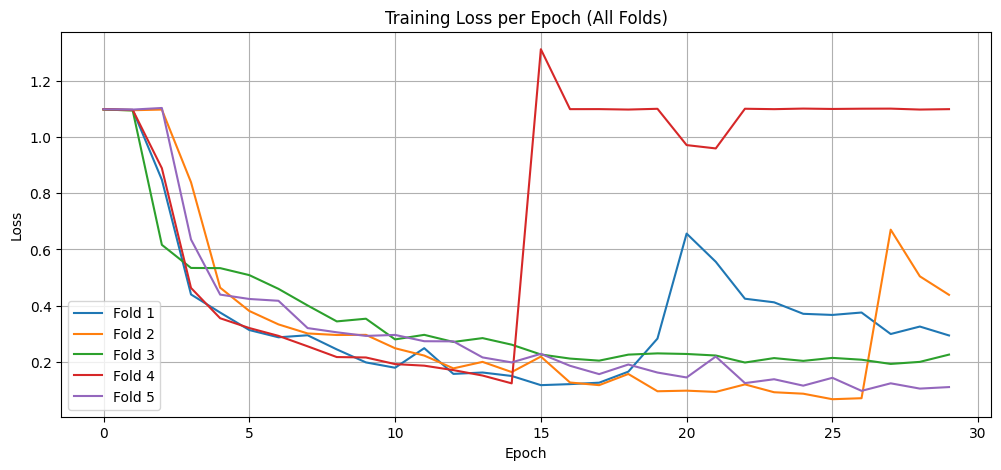

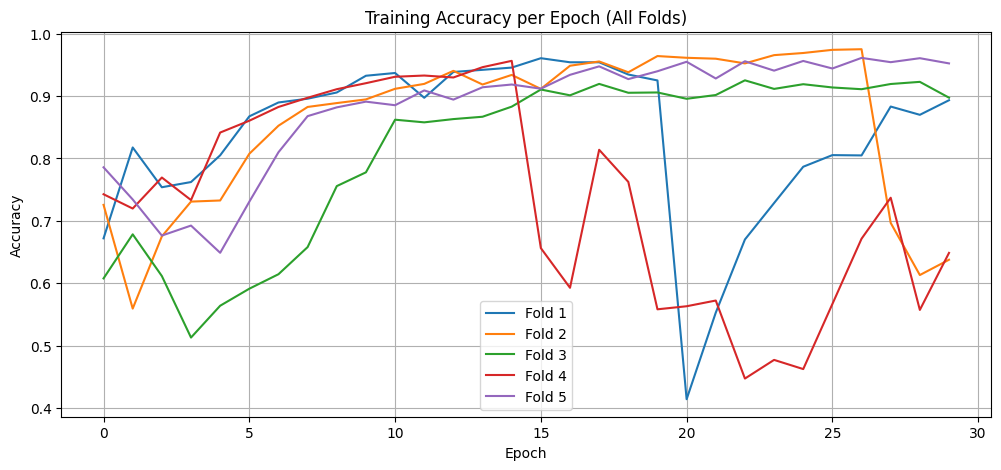

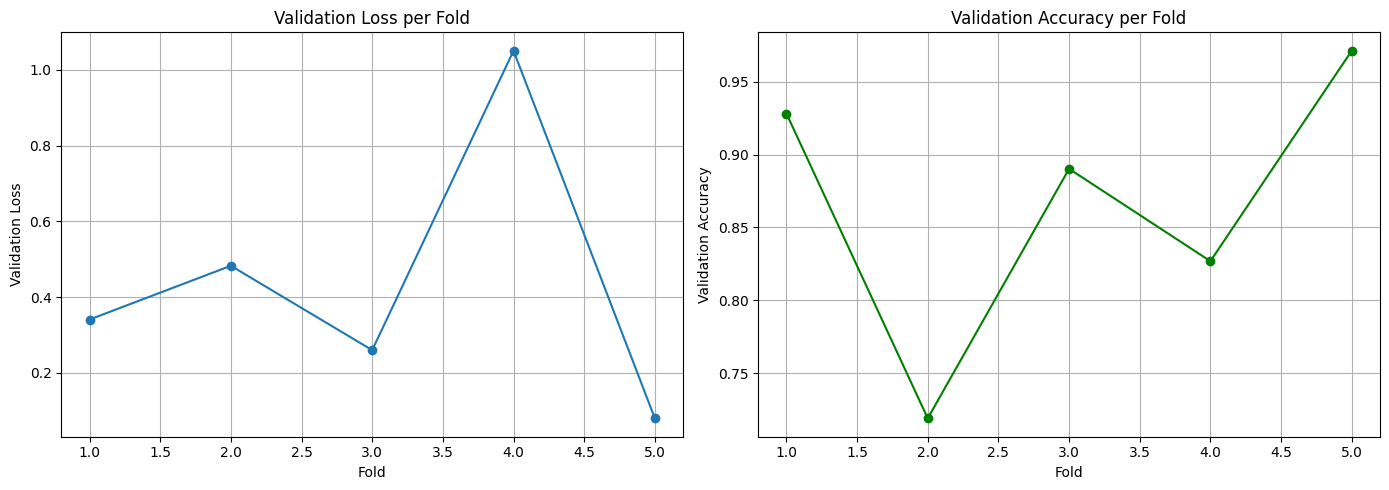

In [ ]:
import matplotlib.pyplot as plt

results = cv_result
lstm_results = cv_result

plt.figure(figsize=(12, 5))
for i, fold_losses in enumerate(results['loss_curve']['train']):
    plt.plot(fold_losses, label=f'Fold {i+1}')
plt.title('Training Loss per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for i, fold_acc in enumerate(results['acc_curve']['train']):
    plt.plot(fold_acc, label=f'Fold {i+1}')
plt.title('Training Accuracy per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(range(1, 6), [x[0] for x in results['loss_curve']['val']], marker='o')
axs[0].set_title('Validation Loss per Fold')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Validation Loss')
axs[0].grid(True)

axs[1].plot(range(1, 6), results['acc_curve']['val'], marker='o', color='green')
axs[1].set_title('Validation Accuracy per Fold')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Validation Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()

GRU

In [ ]:
lr = best_results['GRU']['lr']
num_epochs = 30
model_class = GRUModel
model_params = {
            'input_size': best_results['GRU']['hyperparams']['input_size'],
            'hidden_size': best_results['GRU']['hyperparams']['hidden_size'],
            'num_layers': best_results['GRU']['hyperparams']['num_layers'],
            'output_size': best_results['GRU']['hyperparams']['output_size'],
            'dropout': best_results['GRU']['hyperparams']['dropout']
        }
print(f"Model: GRU lr={lr}")
print(model_params)


# Train
cv_result = cross_val(model_class, model_params, train_sequences, train_seq_labels, batch_size, num_epochs, lr, weight_tensor, device)

#Checkpointing
trained_model = cv_result["best"]["model"]
optimizer = cv_result["best"]["optimizer"]
save_checkpoint(trained_model, optimizer,num_epochs, "/content/drive/MyDrive/DL_Project/gru_model_30.pth")

# Results
print(f'Accuracy  {cv_result["best"]["acc"]}')
print(f'Macro f1 score {cv_result["best"]["f1"]}')
print(f'Report\n {cv_result["best"]["report"]}')
print(f'confusion matrix\n {cv_result["best"]["mat"]}')
print(f'Mean Accuracy: {cv_result["mean-acc"]}')
print(f'Standard Deviation of Accuracy: {cv_result["std-acc"]}')

Model: GRU lr=0.001
{'input_size': 1, 'hidden_size': 100, 'num_layers': 2, 'output_size': 3, 'dropout': 0.0}

 Fold 1
Fold 1, Epoch 1/30, Train Loss = 1.0988, Train Acc = 0.6340
Fold 1, Epoch 2/30, Train Loss = 0.9127, Train Acc = 0.6861
Fold 1, Epoch 3/30, Train Loss = 0.5250, Train Acc = 0.6773
Fold 1, Epoch 4/30, Train Loss = 0.3657, Train Acc = 0.8538
Fold 1, Epoch 5/30, Train Loss = 0.3221, Train Acc = 0.8673
Fold 1, Epoch 6/30, Train Loss = 0.3186, Train Acc = 0.8631
Fold 1, Epoch 7/30, Train Loss = 0.2528, Train Acc = 0.9087
Fold 1, Epoch 8/30, Train Loss = 0.2006, Train Acc = 0.9212
Fold 1, Epoch 9/30, Train Loss = 0.2840, Train Acc = 0.9147
Fold 1, Epoch 10/30, Train Loss = 0.2128, Train Acc = 0.9139
Fold 1, Epoch 11/30, Train Loss = 0.1326, Train Acc = 0.9345
Fold 1, Epoch 12/30, Train Loss = 0.0899, Train Acc = 0.9686
Fold 1, Epoch 13/30, Train Loss = 0.9440, Train Acc = 0.6469
Fold 1, Epoch 14/30, Train Loss = 1.0740, Train Acc = 0.6180
Fold 1, Epoch 15/30, Train Loss = 1.0

##### Plots

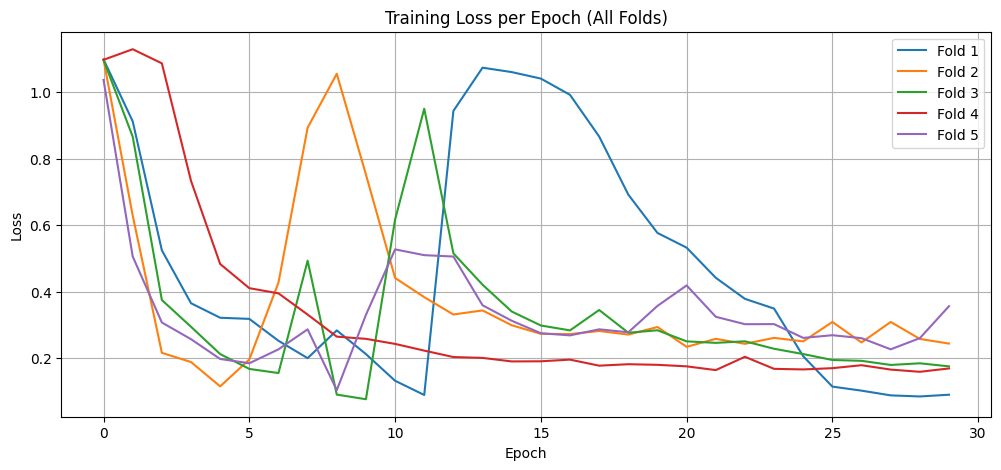

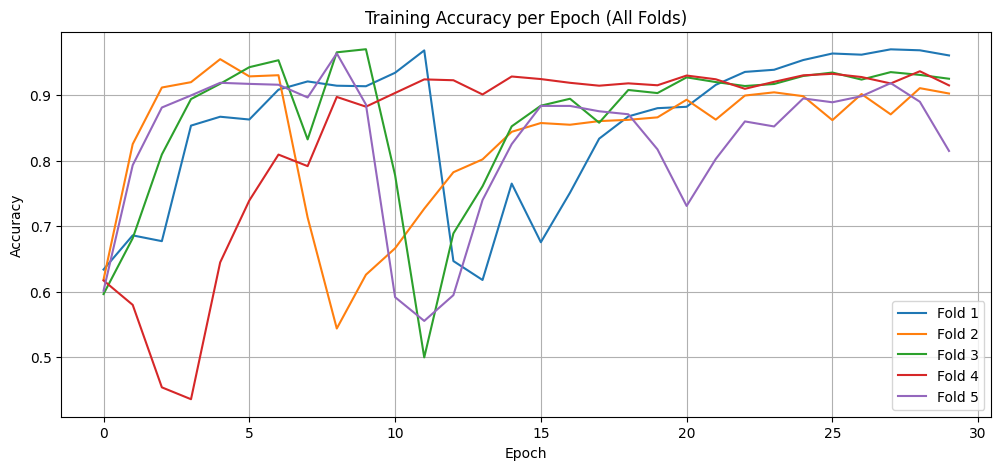

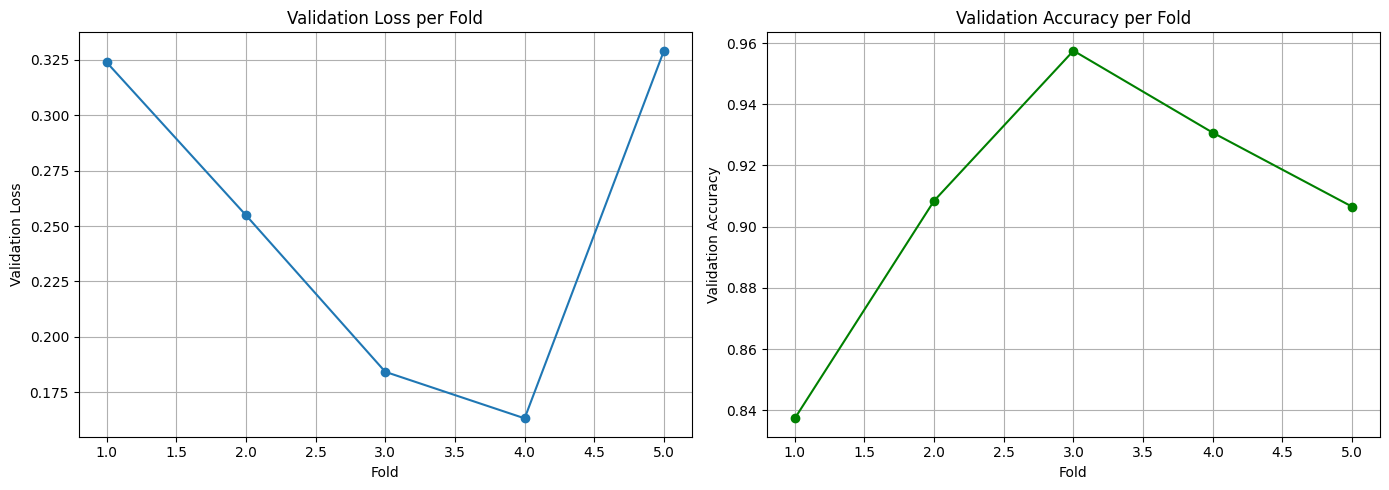

In [ ]:
import matplotlib.pyplot as plt

results = cv_result
gru_results = cv_result

plt.figure(figsize=(12, 5))
for i, fold_losses in enumerate(results['loss_curve']['train']):
    plt.plot(fold_losses, label=f'Fold {i+1}')
plt.title('Training Loss per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for i, fold_acc in enumerate(results['acc_curve']['train']):
    plt.plot(fold_acc, label=f'Fold {i+1}')
plt.title('Training Accuracy per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(range(1, 6), [x[0] for x in results['loss_curve']['val']], marker='o')
axs[0].set_title('Validation Loss per Fold')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Validation Loss')
axs[0].grid(True)

axs[1].plot(range(1, 6), results['acc_curve']['val'], marker='o', color='green')
axs[1].set_title('Validation Accuracy per Fold')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Validation Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()

RNN

In [ ]:
lr = best_results['RNN']['lr']
num_epochs = 30
model_class = RNNModel
model_params = {
            'input_size': best_results['RNN']['hyperparams']['input_size'],
            'hidden_size': best_results['RNN']['hyperparams']['hidden_size'],
            'num_layers': best_results['RNN']['hyperparams']['num_layers'],
            'output_size': best_results['RNN']['hyperparams']['output_size'],
            'dropout': best_results['RNN']['hyperparams']['dropout']
        }
print(f"Model: {model_name} lr={lr}")
print(model_params)


# Training
cv_result = cross_val(model_class, model_params, train_sequences, train_seq_labels, batch_size, num_epochs, lr, weight_tensor, device)

# Checkpointing
trained_model = cv_result["best"]["model"]
optimizer = cv_result["best"]["optimizer"]
save_checkpoint(trained_model, optimizer,num_epochs, "/content/drive/MyDrive/DL_Project/rnn_model_30.pth")

# Results
print(f'Accuracy  {cv_result["best"]["acc"]}')
print(f'Macro f1 score {cv_result["best"]["f1"]}')
print(f'Report\n {cv_result["best"]["report"]}')
print(f'confusion matrix\n {cv_result["best"]["mat"]}')
print(f'Mean Accuracy: {cv_result["mean-acc"]}')
print(f'Standard Deviation of Accuracy: {cv_result["std-acc"]}')

Model: <class '__main__.RNNModel'> lr=0.0005
{'input_size': 1, 'hidden_size': 50, 'num_layers': 2, 'output_size': 3, 'dropout': 0.0}

 Fold 1
Fold 1, Epoch 1/30, Train Loss = 1.0986, Train Acc = 0.7056
Fold 1, Epoch 2/30, Train Loss = 0.7823, Train Acc = 0.5727
Fold 1, Epoch 3/30, Train Loss = 0.4846, Train Acc = 0.6144
Fold 1, Epoch 4/30, Train Loss = 0.4818, Train Acc = 0.5997
Fold 1, Epoch 5/30, Train Loss = 0.4501, Train Acc = 0.6062
Fold 1, Epoch 6/30, Train Loss = 0.4844, Train Acc = 0.5876
Fold 1, Epoch 7/30, Train Loss = 0.4667, Train Acc = 0.6186
Fold 1, Epoch 8/30, Train Loss = 0.4237, Train Acc = 0.6123
Fold 1, Epoch 9/30, Train Loss = 0.4120, Train Acc = 0.6248
Fold 1, Epoch 10/30, Train Loss = 0.3791, Train Acc = 0.7363
Fold 1, Epoch 11/30, Train Loss = 0.3450, Train Acc = 0.7871
Fold 1, Epoch 12/30, Train Loss = 0.3210, Train Acc = 0.8288
Fold 1, Epoch 13/30, Train Loss = 0.3388, Train Acc = 0.8126
Fold 1, Epoch 14/30, Train Loss = 0.3294, Train Acc = 0.8230
Fold 1, Epoch

##### Plots

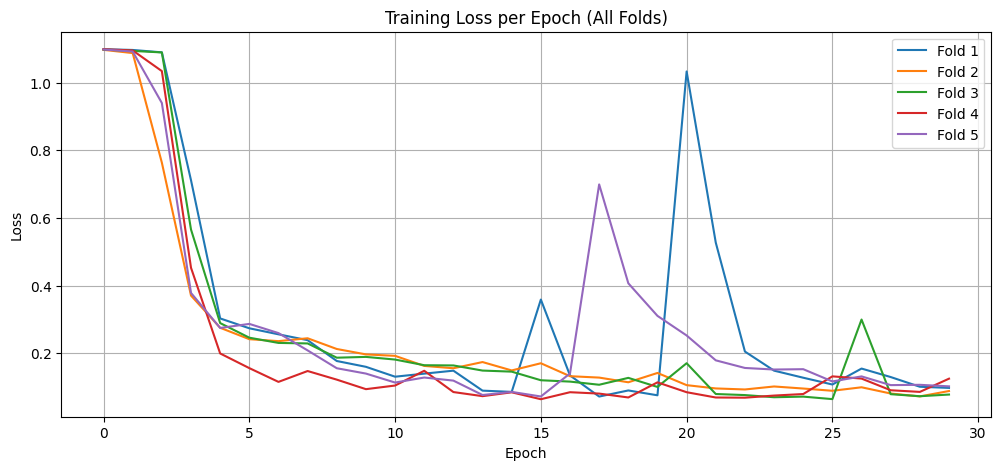

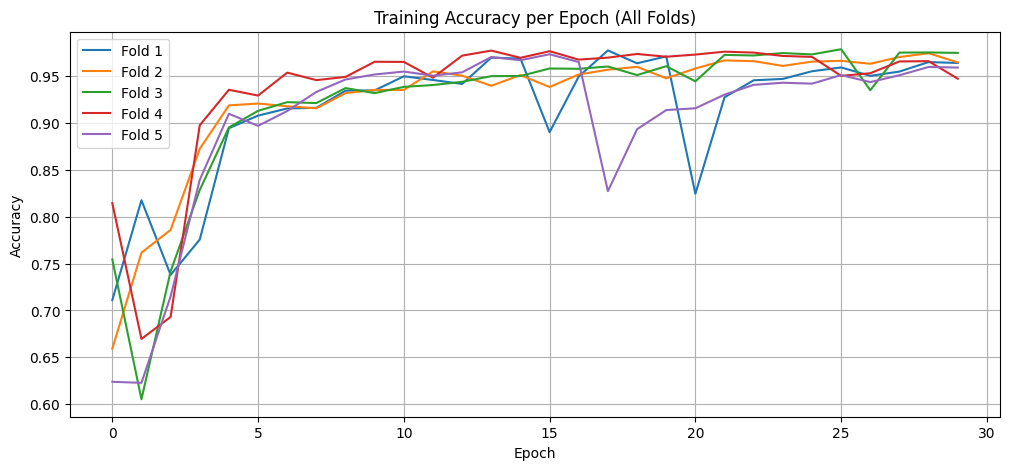

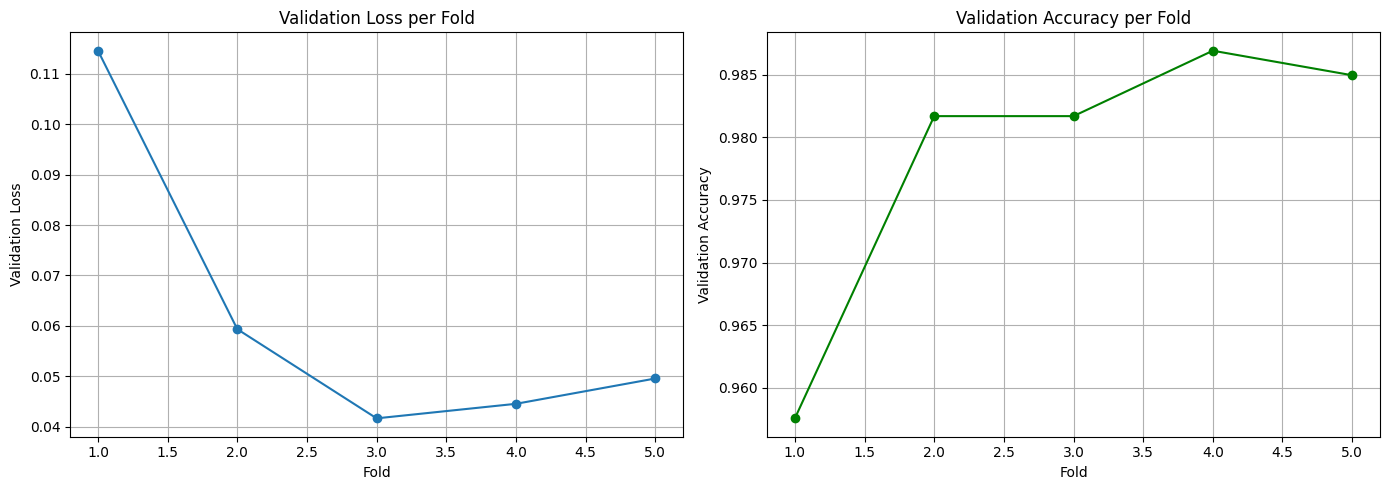

In [ ]:
import matplotlib.pyplot as plt

results = cv_result
rnn_results = cv_result

plt.figure(figsize=(12, 5))
for i, fold_losses in enumerate(results['loss_curve']['train']):
    plt.plot(fold_losses, label=f'Fold {i+1}')
plt.title('Training Loss per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for i, fold_acc in enumerate(results['acc_curve']['train']):
    plt.plot(fold_acc, label=f'Fold {i+1}')
plt.title('Training Accuracy per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(range(1, 6), [x[0] for x in results['loss_curve']['val']], marker='o')
axs[0].set_title('Validation Loss per Fold')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Validation Loss')
axs[0].grid(True)

axs[1].plot(range(1, 6), results['acc_curve']['val'], marker='o', color='green')
axs[1].set_title('Validation Accuracy per Fold')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Validation Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### CNN

In [ ]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters=64, kernel_size=3, dropout=0.3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1) # Conv
        self.relu = nn.ReLU() # Relu
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.dropout = nn.Dropout(dropout) # Dropout
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        # x shape: (batch, num_cols, features)  transpose for Conv1D
        x = x.permute(0, 2, 1)  #  (batch, features, num_cols)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)  #  (batch, num_filters)
        x = self.dropout(x)
        x = self.fc(x)  #  (batch, output_size)
        return x


In [ ]:
input_size = train_sequences.shape[2]   # num_features
output_size = 3                         # number of classes
batch_size = 32
num_epochs = 10



In [ ]:
cnn_param_grid = {
    'num_filters': [32],
    'kernel_size': [3, 5],
    'learning_rate' :[0.001]
}

# Grid Search
import itertools
cnn_combinations = list(itertools.product(cnn_param_grid['num_filters'],
                                          cnn_param_grid['kernel_size'],
                                          cnn_param_grid['learning_rate']))

### Grid Search

In [ ]:
cnn_results ={}
for num_filters, kernel_size, lr in cnn_combinations:
    best_f1 =0
    model_params = {
        'input_size': input_size,
        'output_size': output_size,
        'num_filters': num_filters,
        'kernel_size': kernel_size
    }
    print(f"\nTraining CNN with hyper params filters={num_filters}, kernel={kernel_size}, Learning_rate={lr}")
    weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device) # Weight for Optimizer
    criterion = nn.CrossEntropyLoss(weight=weight_tensor) # Loss
    # Training
    cv_result = cross_val(CNNModel, model_params, train_sequences, train_seq_labels,
                          batch_size, num_epochs, lr, weight_tensor, device)

    # Cache the best hyper params
    if cv_result["best"]["f1"] > best_f1:
            best_f1 =  cv_result["best"]["f1"]
            cnn_results = {
                "hyperparams" : model_params,
                "f1": best_f1,
                "report": cv_result["best"]["report"],
                "conf_mat": cv_result["best"]["mat"],
                "lr": lr
            }


Training CNN with hyper params filters=32, kernel=3, Learning_rate=0.001

 Fold 1
Fold 1, Epoch 1/10, Train Loss = 1.0097, Train Acc = 0.6356
Fold 1, Epoch 2/10, Train Loss = 0.8064, Train Acc = 0.8085
Fold 1, Epoch 3/10, Train Loss = 0.6553, Train Acc = 0.7966
Fold 1, Epoch 4/10, Train Loss = 0.5419, Train Acc = 0.8183
Fold 1, Epoch 5/10, Train Loss = 0.4804, Train Acc = 0.7868
Fold 1, Epoch 6/10, Train Loss = 0.4312, Train Acc = 0.7897
Fold 1, Epoch 7/10, Train Loss = 0.3883, Train Acc = 0.7858
Fold 1, Epoch 8/10, Train Loss = 0.3703, Train Acc = 0.7892
Fold 1, Epoch 9/10, Train Loss = 0.3482, Train Acc = 0.8054
Fold 1, Epoch 10/10, Train Loss = 0.3371, Train Acc = 0.8039
Macro f1 0.8277999433648896
Classification report 
               precision    recall  f1-score   support

     Class 0       0.98      0.86      0.92      1243
     Class 3       1.00      0.97      0.98       129
     Class 1       0.44      0.86      0.58       159

    accuracy                           0.87   

### Display Best Hyper params

In [ ]:
# print(f'Model { model} ')
print(f'Hyperparams { cnn_results["hyperparams"]}')
print(f'Macro f1 score {cnn_results["f1"]}')
print(f'Report\n {cnn_results["report"]}')
print(f'Confusion matrix\n {cnn_results["conf_mat"]}')

Hyperparams {'input_size': 1, 'output_size': 3, 'num_filters': 32, 'kernel_size': 5}
Macro f1 score 0.8199171693217164
Report
               precision    recall  f1-score   support

     Class 0       0.99      0.83      0.90      1243
     Class 3       1.00      0.98      0.99       129
     Class 1       0.41      0.94      0.57       159

    accuracy                           0.85      1531
   macro avg       0.80      0.92      0.82      1531
weighted avg       0.93      0.85      0.87      1531

Confusion matrix
 [[1027    0  216]
 [   3  126    0]
 [   9    0  150]]


### CNN

In [ ]:
lr = cnn_results["lr"]
num_epochs = 30
model_class = CNNModel
model_params = {
        'input_size': cnn_results["hyperparams"]["input_size"],
        'output_size': cnn_results["hyperparams"]["output_size"],
        'num_filters': cnn_results["hyperparams"]["num_filters"],
        'kernel_size': cnn_results["hyperparams"]["kernel_size"]
    }
dropout  = 0.3
print(f"Model: 'CNN', dropout={dropout}, lr={lr}")
print(model_params)


# Training
cv_result = cross_val(model_class, model_params, train_sequences, train_seq_labels, batch_size, num_epochs, lr, weight_tensor, device)

# Checkpointing
trained_model = cv_result["best"]["model"]
optimizer = cv_result["best"]["optimizer"]
save_checkpoint(trained_model, optimizer,num_epochs, "/content/drive/MyDrive/DL_Project/cnn_model_30.pth")

# Results
print(f'Accuracy  {cv_result["best"]["acc"]}')
print(f'Macro f1 score {cv_result["best"]["f1"]}')
print(f'Report\n {cv_result["best"]["report"]}')
print(f'confusion matrix\n {cv_result["best"]["mat"]}')
print(f'Mean Accuracy: {cv_result["mean-acc"]}')
print(f'Standard Deviation of Accuracy: {cv_result["std-acc"]}')

Model: 'CNN', dropout=0.3, lr=0.001
{'input_size': 1, 'output_size': 3, 'num_filters': 32, 'kernel_size': 5}

 Fold 1
Fold 1, Epoch 1/30, Train Loss = 1.0516, Train Acc = 0.5801
Fold 1, Epoch 2/30, Train Loss = 0.8568, Train Acc = 0.7593
Fold 1, Epoch 3/30, Train Loss = 0.6200, Train Acc = 0.7484
Fold 1, Epoch 4/30, Train Loss = 0.4908, Train Acc = 0.7631
Fold 1, Epoch 5/30, Train Loss = 0.4260, Train Acc = 0.7477
Fold 1, Epoch 6/30, Train Loss = 0.3827, Train Acc = 0.7624
Fold 1, Epoch 7/30, Train Loss = 0.3523, Train Acc = 0.7719
Fold 1, Epoch 8/30, Train Loss = 0.3289, Train Acc = 0.7799
Fold 1, Epoch 9/30, Train Loss = 0.3109, Train Acc = 0.7884
Fold 1, Epoch 10/30, Train Loss = 0.3029, Train Acc = 0.7891
Fold 1, Epoch 11/30, Train Loss = 0.2861, Train Acc = 0.8015
Fold 1, Epoch 12/30, Train Loss = 0.2767, Train Acc = 0.8152
Fold 1, Epoch 13/30, Train Loss = 0.2689, Train Acc = 0.8119
Fold 1, Epoch 14/30, Train Loss = 0.2591, Train Acc = 0.8185
Fold 1, Epoch 15/30, Train Loss = 0.2

##### Plots

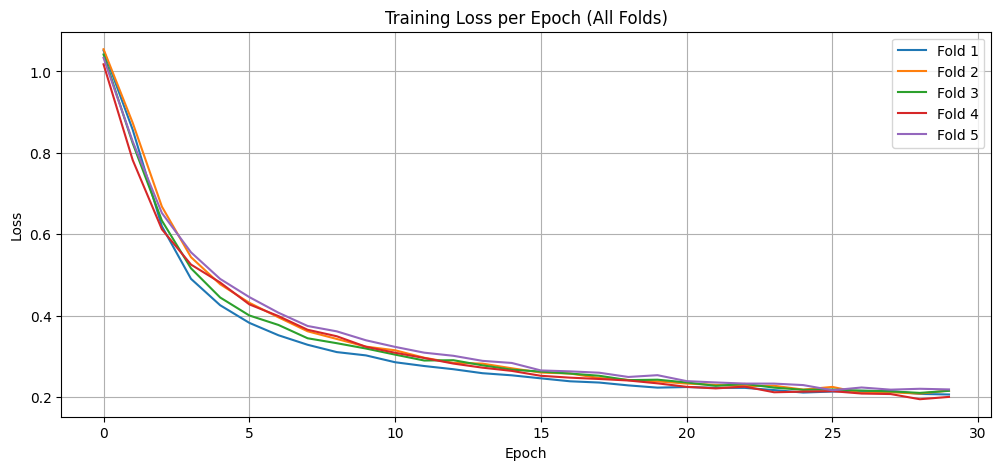

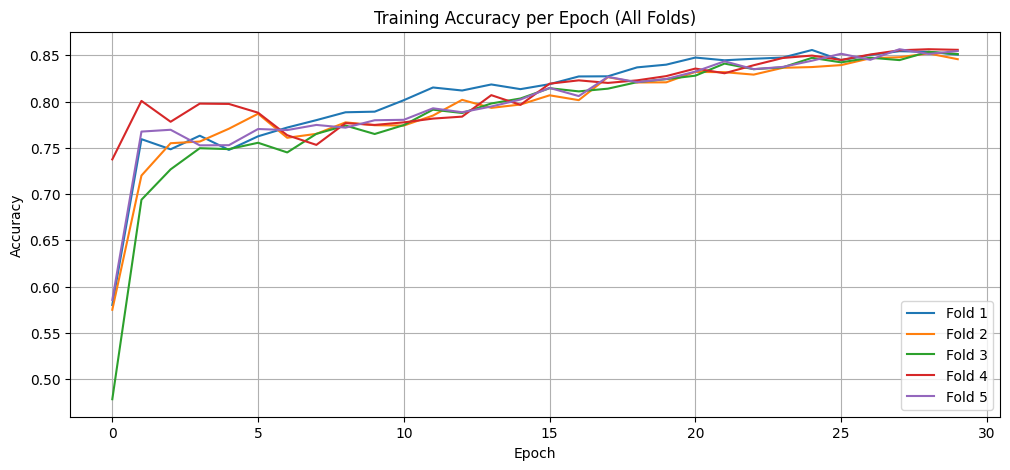

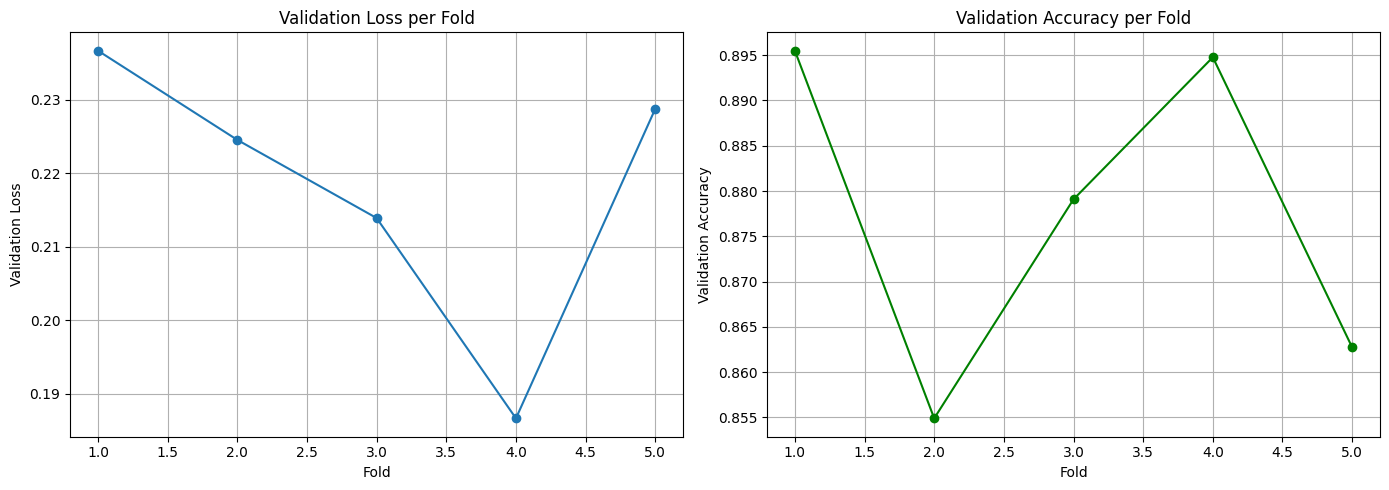

In [ ]:
import matplotlib.pyplot as plt

results = cv_result
cnn_results = cv_result

plt.figure(figsize=(12, 5))
for i, fold_losses in enumerate(results['loss_curve']['train']):
    plt.plot(fold_losses, label=f'Fold {i+1}')
plt.title('Training Loss per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for i, fold_acc in enumerate(results['acc_curve']['train']):
    plt.plot(fold_acc, label=f'Fold {i+1}')
plt.title('Training Accuracy per Epoch (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(range(1, 6), [x[0] for x in results['loss_curve']['val']], marker='o')
axs[0].set_title('Validation Loss per Fold')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Validation Loss')
axs[0].grid(True)

axs[1].plot(range(1, 6), results['acc_curve']['val'], marker='o', color='green')
axs[1].set_title('Validation Accuracy per Fold')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Validation Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Preprocesing data

In [ ]:
import torch # importing the necesary libraries
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from torch.utils.data import TensorDataset

In [ ]:
# Load dataset
df = pd.read_csv("/content/pirvision_office_dataset1.csv")

In [ ]:
# Create a datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%d-%m %H:%M:%S')
df['Hour'] = df['Datetime'].dt.hour
df['Weekday'] = df['Datetime'].dt.day_name()

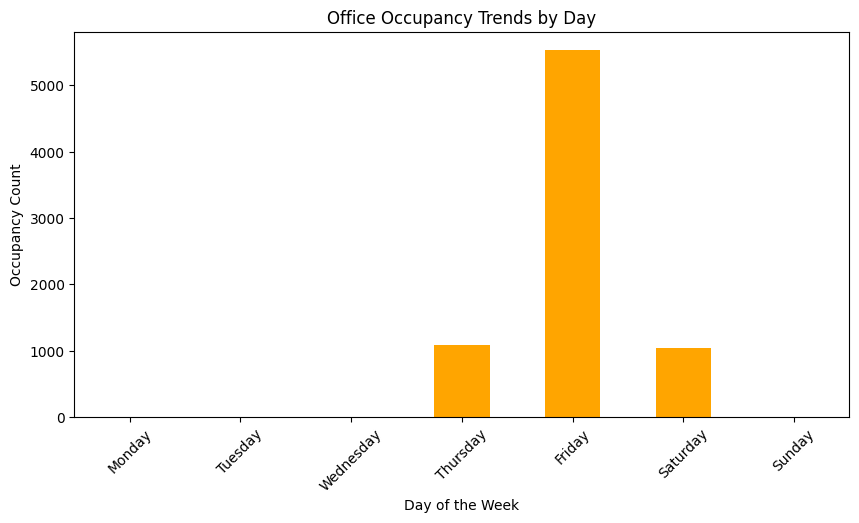

In [ ]:
# Compare weekday vs. weekend occupancy
# Define the correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Sort data according to this order
df_weekday = df.groupby("Weekday")["Label"].count().reindex(weekday_order)

# Plot with corrected order
plt.figure(figsize=(10,5))
df_weekday.plot(kind="bar", color="orange")
plt.xlabel("Day of the Week")
plt.ylabel("Occupancy Count")
plt.title("Office Occupancy Trends by Day")
plt.xticks(rotation=45)
plt.show()

This shows that days of the week have an impact on the occupancy count and thus the type of the activity

<Figure size 1000x500 with 0 Axes>

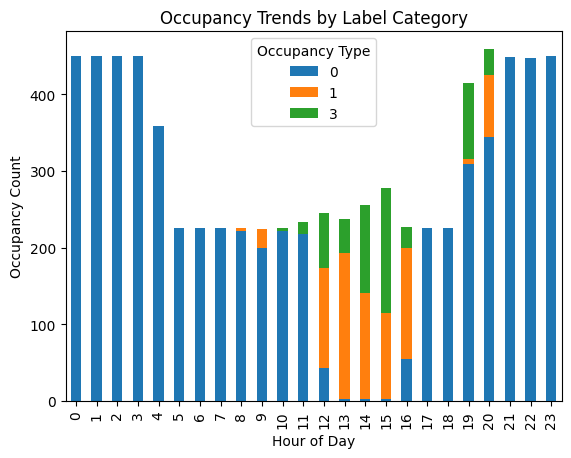

In [ ]:
# Differentiate occupancy categories (Label-based trend)**
plt.figure(figsize=(10,5))
df.groupby(["Hour", "Label"])["Label"].count().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Hour of Day")
plt.ylabel("Occupancy Count")
plt.title("Occupancy Trends by Label Category")
plt.legend(title="Occupancy Type")
plt.show()


This shows that the hours of the day has an impact on the type of the class. Late hours are mainly occupied by class 0 (Likely no activity class). Class 1 and 3 mainly occurs in the mid-day hours.

# Encoder Transformer model

Preprocess data

In [ ]:
def process_datetime(df):
    """Enhances date features by encoding hour, day, and cyclic time patterns."""

    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df['Hour'] = df['Datetime'].dt.hour
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # Direct integer encoding (0 = Monday, ..., 6 = Sunday)
    df['Day'] = df['Datetime'].dt.day

    # Cyclic encoding for Hour (sin/cos)
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

    # Cyclic encoding for Day (sin/cos) to reflect monthly variations
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for Saturday/Sunday, 0 for Monday-Friday

    df = df.rename(columns={'Temperature_F': 'Temperature'})

    # One-hot encode DayOfWeek
    df = pd.get_dummies(df, columns=['DayOfWeek'])

    # Normalize numerical features
    scaler = StandardScaler()
    df[['Temperature', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos']] = scaler.fit_transform(df[['Temperature', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos']])

    # Label encoding for classification
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])

    return df


PIR dataset

In [ ]:
class PIRDataset(Dataset):
    def __init__(self, df):
        self.pir_values = torch.tensor(df.iloc[:, 4:59].values, dtype=torch.float32)  # PIR readings
        self.tabular_features = torch.tensor(df[['Temperature', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'IsWeekend']].values, dtype=torch.float32)
        self.labels = torch.tensor(df['Label'].values, dtype=torch.long)  # Classification labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.pir_values[idx], self.tabular_features[idx], self.labels[idx]


Transformer model

In [ ]:
class OccupancyTransformer(nn.Module):
    def __init__(self, num_pir_features, num_tabular_features, num_classes, d_model=64, nhead=4, num_layers=2):
        super(OccupancyTransformer, self).__init__()

        # Transformer Encoder for PIR sensor data
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_time_series = nn.Linear(num_pir_features, d_model)

        # Dense layer for tabular features
        self.fc_tabular = nn.Linear(num_tabular_features, d_model)

        # Classifier
        self.fc_combined = nn.Linear(2 * d_model, num_classes)

    def forward(self, pir_values, tabular_features):
        pir_values = self.fc_time_series(pir_values).unsqueeze(1)  # Align with PIR feature order
        pir_encoded = self.transformer(pir_values).squeeze(1)

        tabular_encoded = self.fc_tabular(tabular_features)

        combined_features = torch.cat((pir_encoded, tabular_encoded), dim=-1)
        output = self.fc_combined(combined_features)

        return output


load and preprocess dataset

In [ ]:
# Train the Model
df = pd.read_csv("/content/pirvision_office_dataset1.csv")  # Load dataset
df = process_datetime(df)  # Process Date & Time features
dataset = PIRDataset(df)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
labels_all = [dataset[i][2] for i in range(len(dataset))]

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

Defining weights for classes to handle imbalance of data

In [ ]:
class_weights = [1.1, 1.2, 1.25]

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define Cross-Entropy Loss with weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

<ipython-input-44-0ace5efc762d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
# train model

# Hyperparameters
num_pir_features = 55
num_tabular_features = 6  # Temperature + Hour_sin + Hour_cos + day_sin + day_cos + isWeekend
num_classes = len(df['Label'].unique())

Train with cross validation

In [ ]:
# Training function with Cross-Validation
def train_model_cv(dataset, num_epochs=30):
    fold = 1
    accuracy_scores = [] # arrays to store the evaluation metrics
    macro_f1_scores = []
    class_precision = []
    class_recall = []
    class_f1 = []
    confusion_matrices = []

    for train_idx, val_idx in kf.split(dataset, labels_all): # for each fold
        print(f" Training Fold {fold}/5...")

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler) # train and validation data loader
        val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

        model = OccupancyTransformer(num_pir_features, num_tabular_features, num_classes) # define model

        optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

        model.train()
        for epoch in range(num_epochs): # for each epoch
            total_loss = 0
            for pir_values, tabular_features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(pir_values, tabular_features) # model predictions
                loss = criterion(outputs, labels) # loss calculated
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f" Fold {fold}, Epoch {epoch+1}, Loss: {total_loss:.4f}")

        # Evaluate model on validation set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for pir_values, tabular_features, labels in val_loader:
                outputs = model(pir_values, tabular_features)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Accuracy score
        fold_accuracy = accuracy_score(all_labels, all_preds)
        accuracy_scores.append(fold_accuracy)

        # Macro F1-Score
        fold_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        macro_f1_scores.append(fold_macro_f1)

        # Class-wise Precision, Recall, F1
        fold_precision = precision_score(all_labels, all_preds, average=None)
        fold_recall = recall_score(all_labels, all_preds, average=None)
        fold_f1 = f1_score(all_labels, all_preds, average=None)

        class_precision.append(fold_precision)
        class_recall.append(fold_recall)
        class_f1.append(fold_f1)

        # Confusion Matrix
        fold_conf_matrix = confusion_matrix(all_labels, all_preds)
        confusion_matrices.append(fold_conf_matrix)

        print(f" Fold {fold} Accuracy: {fold_accuracy:.4f}")
        print(f" Fold {fold} Macro F1-Score: {fold_macro_f1:.4f}")
        print(f" Fold {fold} Class-wise Precision: {fold_precision}")
        print(f" Fold {fold} Class-wise Recall: {fold_recall}")
        print(f" Fold {fold} Class-wise F1: {fold_f1}")
        print(f" Fold {fold} Confusion Matrix: \n{fold_conf_matrix}\n")

        torch.save({  # saving model of each epoch
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': total_loss,
        }, f"team_40_transformer_fold_{fold}.pth")

        fold += 1

    # Report Mean and Standard Deviation for each metric
    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)

    mean_macro_f1 = np.mean(macro_f1_scores)
    std_macro_f1 = np.std(macro_f1_scores)

    mean_class_precision = np.mean(class_precision, axis=0)
    mean_class_recall = np.mean(class_recall, axis=0)
    mean_class_f1 = np.mean(class_f1, axis=0)

    # Print the results
    print(f" **Final Model Evaluation**:")
    print(f" Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f" Mean Macro F1-Score: {mean_macro_f1:.4f} ± {std_macro_f1:.4f}")
    print(f" Mean Class-wise Precision: {mean_class_precision}")
    print(f" Mean Class-wise Recall: {mean_class_recall}")
    print(f" Mean Class-wise F1: {mean_class_f1}")

    # Aggregate confusion matrix across all folds
    total_conf_matrix = np.sum(confusion_matrices, axis=0)
    print(f" Total Confusion Matrix: \n{total_conf_matrix}")

# Run 5-Fold Cross Validation
train_model_cv(dataset)


 Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 Fold 1, Epoch 1, Loss: 57.3750
 Fold 1, Epoch 2, Loss: 32.8938
 Fold 1, Epoch 3, Loss: 32.1097
 Fold 1, Epoch 4, Loss: 31.0684
 Fold 1, Epoch 5, Loss: 31.2098
 Fold 1, Epoch 6, Loss: 31.0591
 Fold 1, Epoch 7, Loss: 31.2217
 Fold 1, Epoch 8, Loss: 31.1590
 Fold 1, Epoch 9, Loss: 31.0392
 Fold 1, Epoch 10, Loss: 31.0543
 Fold 1, Epoch 11, Loss: 30.9540
 Fold 1, Epoch 12, Loss: 31.1499
 Fold 1, Epoch 13, Loss: 30.7177
 Fold 1, Epoch 14, Loss: 31.1139
 Fold 1, Epoch 15, Loss: 30.9809
 Fold 1, Epoch 16, Loss: 30.8053
 Fold 1, Epoch 17, Loss: 31.0526
 Fold 1, Epoch 18, Loss: 31.1412
 Fold 1, Epoch 19, Loss: 30.8686
 Fold 1, Epoch 20, Loss: 31.4439
 Fold 1, Epoch 21, Loss: 31.3633
 Fold 1, Epoch 22, Loss: 30.9596
 Fold 1, Epoch 23, Loss: 31.0005
 Fold 1, Epoch 24, Loss: 31.0447
 Fold 1, Epoch 25, Loss: 31.0478
 Fold 1, Epoch 26, Loss: 30.9715
 Fold 1, Epoch 27, Loss: 30.6880
 Fold 1, Epoch 28, Loss: 30.9153
 Fold 1, Epoch 29, Loss: 30.8689
 Fold 1, Epoch 30, Loss: 30.9378
 Fold 1 Accuracy: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 Fold 2, Epoch 1, Loss: 52.4392
 Fold 2, Epoch 2, Loss: 31.7040
 Fold 2, Epoch 3, Loss: 30.9673
 Fold 2, Epoch 4, Loss: 31.1078
 Fold 2, Epoch 5, Loss: 30.9042
 Fold 2, Epoch 6, Loss: 30.5502
 Fold 2, Epoch 7, Loss: 30.6800
 Fold 2, Epoch 8, Loss: 30.6090
 Fold 2, Epoch 9, Loss: 30.4998
 Fold 2, Epoch 10, Loss: 30.3713
 Fold 2, Epoch 11, Loss: 30.5923
 Fold 2, Epoch 12, Loss: 30.2693
 Fold 2, Epoch 13, Loss: 30.4422
 Fold 2, Epoch 14, Loss: 30.6322
 Fold 2, Epoch 15, Loss: 30.6030
 Fold 2, Epoch 16, Loss: 30.5515
 Fold 2, Epoch 17, Loss: 30.4946
 Fold 2, Epoch 18, Loss: 30.5913
 Fold 2, Epoch 19, Loss: 30.5463
 Fold 2, Epoch 20, Loss: 30.3256
 Fold 2, Epoch 21, Loss: 30.2919
 Fold 2, Epoch 22, Loss: 30.7598
 Fold 2, Epoch 23, Loss: 30.6699
 Fold 2, Epoch 24, Loss: 30.5222
 Fold 2, Epoch 25, Loss: 30.5749
 Fold 2, Epoch 26, Loss: 30.4561
 Fold 2, Epoch 27, Loss: 30.3582
 Fold 2, Epoch 28, Loss: 30.6300
 Fold 2, Epoch 29, Loss: 30.5725
 Fold 2, Epoch 30, Loss: 30.5143
 Fold 2 Accuracy: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 Fold 3, Epoch 1, Loss: 52.1175
 Fold 3, Epoch 2, Loss: 33.0208
 Fold 3, Epoch 3, Loss: 31.5147
 Fold 3, Epoch 4, Loss: 31.8407
 Fold 3, Epoch 5, Loss: 31.2787
 Fold 3, Epoch 6, Loss: 31.2979
 Fold 3, Epoch 7, Loss: 31.5397
 Fold 3, Epoch 8, Loss: 31.4787
 Fold 3, Epoch 9, Loss: 31.3483
 Fold 3, Epoch 10, Loss: 31.1990
 Fold 3, Epoch 11, Loss: 31.4621
 Fold 3, Epoch 12, Loss: 31.3741
 Fold 3, Epoch 13, Loss: 31.4947
 Fold 3, Epoch 14, Loss: 31.3808
 Fold 3, Epoch 15, Loss: 31.6807
 Fold 3, Epoch 16, Loss: 31.2652
 Fold 3, Epoch 17, Loss: 31.3010
 Fold 3, Epoch 18, Loss: 31.3903
 Fold 3, Epoch 19, Loss: 31.1932
 Fold 3, Epoch 20, Loss: 31.1825
 Fold 3, Epoch 21, Loss: 31.5887
 Fold 3, Epoch 22, Loss: 31.5651
 Fold 3, Epoch 23, Loss: 31.2719
 Fold 3, Epoch 24, Loss: 31.1940
 Fold 3, Epoch 25, Loss: 31.1302
 Fold 3, Epoch 26, Loss: 31.8227
 Fold 3, Epoch 27, Loss: 31.6379
 Fold 3, Epoch 28, Loss: 31.3242
 Fold 3, Epoch 29, Loss: 31.5756
 Fold 3, Epoch 30, Loss: 31.1237
 Fold 3 Accuracy: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 Fold 4, Epoch 1, Loss: 49.7306
 Fold 4, Epoch 2, Loss: 31.4271
 Fold 4, Epoch 3, Loss: 30.2892
 Fold 4, Epoch 4, Loss: 30.4308
 Fold 4, Epoch 5, Loss: 30.0562
 Fold 4, Epoch 6, Loss: 29.7047
 Fold 4, Epoch 7, Loss: 30.0909
 Fold 4, Epoch 8, Loss: 30.1226
 Fold 4, Epoch 9, Loss: 29.9043
 Fold 4, Epoch 10, Loss: 30.0116
 Fold 4, Epoch 11, Loss: 29.8841
 Fold 4, Epoch 12, Loss: 29.9568
 Fold 4, Epoch 13, Loss: 29.8387
 Fold 4, Epoch 14, Loss: 30.2692
 Fold 4, Epoch 15, Loss: 30.0632
 Fold 4, Epoch 16, Loss: 29.9559
 Fold 4, Epoch 17, Loss: 29.9222
 Fold 4, Epoch 18, Loss: 29.7290
 Fold 4, Epoch 19, Loss: 29.9178
 Fold 4, Epoch 20, Loss: 30.2004
 Fold 4, Epoch 21, Loss: 30.1490
 Fold 4, Epoch 22, Loss: 30.0659
 Fold 4, Epoch 23, Loss: 29.9464
 Fold 4, Epoch 24, Loss: 30.2917
 Fold 4, Epoch 25, Loss: 29.8895
 Fold 4, Epoch 26, Loss: 29.8099
 Fold 4, Epoch 27, Loss: 29.8899
 Fold 4, Epoch 28, Loss: 29.7314
 Fold 4, Epoch 29, Loss: 29.7751
 Fold 4, Epoch 30, Loss: 29.7829
 Fold 4 Accuracy: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


 Fold 5, Epoch 1, Loss: 53.9818
 Fold 5, Epoch 2, Loss: 31.9565
 Fold 5, Epoch 3, Loss: 31.0385
 Fold 5, Epoch 4, Loss: 30.5423
 Fold 5, Epoch 5, Loss: 30.4421
 Fold 5, Epoch 6, Loss: 30.3634
 Fold 5, Epoch 7, Loss: 30.1517
 Fold 5, Epoch 8, Loss: 30.4390
 Fold 5, Epoch 9, Loss: 30.3456
 Fold 5, Epoch 10, Loss: 30.3826
 Fold 5, Epoch 11, Loss: 30.5233
 Fold 5, Epoch 12, Loss: 30.3553
 Fold 5, Epoch 13, Loss: 30.6537
 Fold 5, Epoch 14, Loss: 30.0182
 Fold 5, Epoch 15, Loss: 30.3892
 Fold 5, Epoch 16, Loss: 30.1992
 Fold 5, Epoch 17, Loss: 30.2870
 Fold 5, Epoch 18, Loss: 30.4286
 Fold 5, Epoch 19, Loss: 30.3427
 Fold 5, Epoch 20, Loss: 30.4033
 Fold 5, Epoch 21, Loss: 30.6293
 Fold 5, Epoch 22, Loss: 30.8136
 Fold 5, Epoch 23, Loss: 29.9944
 Fold 5, Epoch 24, Loss: 30.2331
 Fold 5, Epoch 25, Loss: 30.4804
 Fold 5, Epoch 26, Loss: 30.3421
 Fold 5, Epoch 27, Loss: 30.3105
 Fold 5, Epoch 28, Loss: 30.2658
 Fold 5, Epoch 29, Loss: 30.2302
 Fold 5, Epoch 30, Loss: 30.1741
 Fold 5 Accuracy: 0

# Hybrid Model Combining CNN for PIR (time series) values and MLP for tabular data

In [ ]:
# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Preprocess data

In [ ]:
# --- Load and preprocess ---
df = pd.read_csv("/content/pirvision_office_dataset1.csv")
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
pir_columns = [f'PIR_{i}' for i in range(1, 56)]
tabular_features = ['Temperature_F', 'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos']
X_pir = df[pir_columns].values.astype(np.float32)
X_tab = df[tabular_features].values.astype(np.float32)

<ipython-input-139-61a5d0961713>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour
<ipython-input-139-61a5d0961713>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Minute'] = pd.to_datetime(df['Time']).dt.minute


In [ ]:
label_encoder = LabelEncoder() # label encoder for data
df['Label'] = label_encoder.fit_transform(df['Label'].astype(str))
y = df['Label'].values
print(np.unique(y))

[0 1 2]


In [ ]:
pir_scaler = StandardScaler() # normalization
tab_scaler = StandardScaler()
X_pir = pir_scaler.fit_transform(X_pir)
X_tab = tab_scaler.fit_transform(X_tab)

In [ ]:
X_pir = torch.tensor(X_pir).unsqueeze(1)  # (N, 1, 55)
X_tab = torch.tensor(X_tab)
y = torch.tensor(y)

Hybrid CNN model with FF network

In [ ]:
# --- Model ---
class HybridCNN(nn.Module):
    def __init__(self, input_tab_dim):
        super(HybridCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.tabular_net = nn.Sequential(
            nn.Linear(input_tab_dim, 16),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 + 16, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, pir_input, tab_input):
        cnn_out = self.cnn(pir_input).squeeze(-1)
        tab_out = self.tabular_net(tab_input)
        x = torch.cat([cnn_out, tab_out], dim=1)
        return self.classifier(x)

Training

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # cross validation
accuracies, f1_macros = [], []
class_wise_metrics = {'precision': [], 'recall': [], 'f1': []}
conf_matrices = []

class_counts = np.bincount(y.numpy())
class_weights = torch.tensor(1. / class_counts, dtype=torch.float32) # assigning class weights for handling imbalance

print("Class Weights for Loss:", class_weights.tolist())

for fold, (train_idx, test_idx) in enumerate(skf.split(X_pir, y)): # for each fold
    print(f"\n--- Fold {fold + 1} ---")

    model = HybridCNN(input_tab_dim=X_tab.shape[1]) # model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer
    loss_fn = nn.CrossEntropyLoss(weight=class_weights) # loss function

    train_dataset = TensorDataset(X_pir[train_idx], X_tab[train_idx], y[train_idx]) # train and test loader
    test_dataset = TensorDataset(X_pir[test_idx], X_tab[test_idx], y[test_idx])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.train()
    for epoch in range(30): # for each epoch
        epoch_loss = 0
        for pir_batch, tab_batch, labels in train_loader: # training
            optimizer.zero_grad()
            outputs = model(pir_batch, tab_batch)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1} - Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for pir_batch, tab_batch, labels in test_loader:
            outputs = model(pir_batch, tab_batch)
            pred_labels = torch.argmax(outputs, dim=1)
            preds.extend(pred_labels.numpy())
            trues.extend(labels.numpy())

    acc = accuracy_score(trues, preds) # evaluation metrics calculation
    f1_macro = f1_score(trues, preds, average='macro')
    report = classification_report(trues, preds, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(trues, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print("Class-wise Metrics:")
    for cls in range(3):
        print(f"  Class {cls}: "
              f"Precision: {report[str(cls)]['precision']:.4f}, "
              f"Recall: {report[str(cls)]['recall']:.4f}, "
              f"F1: {report[str(cls)]['f1-score']:.4f}")
    print("Confusion Matrix:")
    print(conf_mat)
    accuracies.append(acc)
    f1_macros.append(f1_macro)
    class_wise_metrics['precision'].append([report[str(i)]['precision'] for i in range(3)])
    class_wise_metrics['recall'].append([report[str(i)]['recall'] for i in range(3)])
    class_wise_metrics['f1'].append([report[str(i)]['f1-score'] for i in range(3)])
    conf_matrices.append(conf_mat)

    torch.save({  # saving model of each epoch
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': epoch_loss,
    }, f"team_40_cnn_hybrid_fold_{fold}.pth")

# --- Summary ---
print("\n=== Cross-Validation Summary ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean Macro F1 Score: {np.mean(f1_macros):.4f}")

avg_precision = np.mean(class_wise_metrics['precision'], axis=0) # average metric values across the folds
avg_recall = np.mean(class_wise_metrics['recall'], axis=0)
avg_f1 = np.mean(class_wise_metrics['f1'], axis=0)
print("\nAverage Class-wise Metrics:")
for cls in range(3):
    print(f"  Class {cls}: "
          f"Precision: {avg_precision[cls]:.4f}, "
          f"Recall: {avg_recall[cls]:.4f}, "
          f"F1: {avg_f1[cls]:.4f}")

print("\nTotal Confusion Matrix Across Folds:")
total_conf_matrix = np.sum(conf_matrices, axis=0)
print(total_conf_matrix)


Class Weights for Loss: [0.0001600768300704658, 0.0012004801537841558, 0.0017513134516775608]

--- Fold 1 ---
Epoch 1 - Loss: 126.8057
Epoch 2 - Loss: 27.2770
Epoch 3 - Loss: 16.5015
Epoch 4 - Loss: 14.2945
Epoch 5 - Loss: 12.8342
Epoch 6 - Loss: 11.7054
Epoch 7 - Loss: 10.7310
Epoch 8 - Loss: 11.4946
Epoch 9 - Loss: 10.2201
Epoch 10 - Loss: 10.2248
Epoch 11 - Loss: 9.3386
Epoch 12 - Loss: 9.0754
Epoch 13 - Loss: 8.7400
Epoch 14 - Loss: 8.3885
Epoch 15 - Loss: 8.5927
Epoch 16 - Loss: 8.0137
Epoch 17 - Loss: 7.4616
Epoch 18 - Loss: 7.4389
Epoch 19 - Loss: 7.3227
Epoch 20 - Loss: 7.4440
Epoch 21 - Loss: 6.5949
Epoch 22 - Loss: 7.5148
Epoch 23 - Loss: 7.2851
Epoch 24 - Loss: 6.1798
Epoch 25 - Loss: 5.7272
Epoch 26 - Loss: 6.9096
Epoch 27 - Loss: 6.1169
Epoch 28 - Loss: 5.8821
Epoch 29 - Loss: 6.0094
Epoch 30 - Loss: 6.5206
Accuracy: 0.9843
Macro F1 Score: 0.9734
Class-wise Metrics:
  Class 0: Precision: 0.9944, Recall: 0.9864, F1: 0.9904
  Class 1: Precision: 0.9034, Recall: 0.9578, F1: 0

### Design Choices

*   Scaler
  * All features, including temperature and PIR sensor readings, were normalized using MinMaxScaler to bring values into a uniform scale between 0 and 1. This was essential for ensuring faster convergence and preventing any single feature from dominating the learning process.

* Model Selection
  * Time series classification task -> RNN-based models are selected RNN, LSTM, and GRU

---

- RNNs capable of learning short-term dependencies but limited by vanishing gradients in longer sequences.
- LSTMs, which use gating mechanisms to retain long-term context
- GRUs are more efficient with fewer parameters, making them ideal for faster training on moderate-sized datasets.

- CNNs to extract local temporal patterns
- Transformers are able to capture long term dependencies well, making them a good choice for the PIRVision dataset.
- CNN coupled with Feedforward network will be able to capture both the tabular features with the help of the feedforward layers and CNN helps in capturing the temporal features.

---

* Grid Search & Cross Validation

  * To Generalizable performance -> 5-fold cross-validation strategy is used training.

  * Partitioned the dataset into five splits, cycling through each as a validation set while training on the remaining folds. -> Reduces Overfitting

  * Grid Search used for Hyperparameter tuning

  * For testing, we evaluated the best model (selected based on validation F1-score)






Evaluation

In [ ]:
import torch # importing the necesary libraries
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from torch.utils.data import TensorDataset

In [ ]:
# --- Load and preprocess ---
def preprocess(path):
    df = pd.read_csv(path)
    df['Hour'] = pd.to_datetime(df['Time']).dt.hour
    df['Minute'] = pd.to_datetime(df['Time']).dt.minute
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
    df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
    pir_columns = [f'PIR_{i}' for i in range(1, 56)]
    tabular_features = ['Temperature_F', 'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos']
    X_pir = df[pir_columns].values.astype(np.float32)
    X_tab = df[tabular_features].values.astype(np.float32)
    label_encoder = LabelEncoder() # label encoder for data
    df['Label'] = label_encoder.fit_transform(df['Label'].astype(str))
    y = df['Label'].values
    print(np.unique(y))
    pir_scaler = StandardScaler() # normalization
    tab_scaler = StandardScaler()
    X_pir = pir_scaler.fit_transform(X_pir)
    X_tab = tab_scaler.fit_transform(X_tab)
    X_pir = torch.tensor(X_pir).unsqueeze(1)
    X_tab = torch.tensor(X_tab)
    y = torch.tensor(y)
    return df, pir_columns, tabular_features, X_pir, X_tab, y

Hybrid CNN model with FF network

In [ ]:
# --- Model ---
class HybridCNN(nn.Module):
    def __init__(self, input_tab_dim):
        super(HybridCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.tabular_net = nn.Sequential(
            nn.Linear(input_tab_dim, 16),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 + 16, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, pir_input, tab_input):
        cnn_out = self.cnn(pir_input).squeeze(-1)
        tab_out = self.tabular_net(tab_input)
        x = torch.cat([cnn_out, tab_out], dim=1)
        return self.classifier(x)

In [ ]:
checkpoint = "/content/team_40_cnn_hybrid_fold_2.pth"

In [ ]:
data_path = "/content/pirvision_office_dataset1.csv"

In [ ]:
def evaluate(data_path, checkpoint):
    df, pir_columns, tabular_features, X_pir, X_tab, y = preprocess(data_path)
    # define model
    model = HybridCNN(input_tab_dim=X_tab.shape[1])
    # load the checkpoint dictionary
    checkpoint = torch.load(checkpoint)

    # load the model weights from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set model to evaluation mode
    model.eval()

    test_dataset = TensorDataset(X_pir, X_tab, y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    preds, trues = [], []

    with torch.no_grad():
        for pir_batch, tab_batch, labels in test_loader:
            outputs = model(pir_batch, tab_batch)
            pred_labels = torch.argmax(outputs, dim=1)
            preds.extend(pred_labels.numpy())
            trues.extend(labels.numpy())

    # Metrics
    acc = accuracy_score(trues, preds)
    f1_macro = f1_score(trues, preds, average='macro')
    report = classification_report(trues, preds)
    conf_mat = confusion_matrix(trues, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_mat)
    return acc

In [ ]:
evaluate(data_path, checkpoint)

<ipython-input-16-d36915198cfc>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour
<ipython-input-16-d36915198cfc>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Minute'] = pd.to_datetime(df['Time']).dt.minute


[0 1 2]
Accuracy: 0.9861
Macro F1 Score: 0.9771
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6247
           1       0.89      0.99      0.94       833
           2       1.00      1.00      1.00       571

    accuracy                           0.99      7651
   macro avg       0.96      0.99      0.98      7651
weighted avg       0.99      0.99      0.99      7651

Confusion Matrix:
[[6147  100    0]
 [   6  827    0]
 [   0    0  571]]
